### Import statements

In [21]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.fft import fft
import pickle
import json
import os
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')


### Exploratory Data Analysis

To begin analyzing the structure of the dataset, I imported the file AAPL.csv, which contains the stock data for Apple Inc. This marks the starting point for exploring the dataset's structure and gaining insights into its contents. I used key pandas functions such as .head(), .info(), and .describe() to perform an initial assessment.

By invoking .head(), I was able to get a look at the first few rows of the dataset, which provided a snapshot of the data format and allowed me to verify the presence of expected columns. Next, .info() was employed to inspect the data types of each column, the number of non-null entries, and the overall memory usage. This step was crucial for identifying any missing values or potential inconsistencies in the data. Finally, I used .describe() to compute summary statistics for numerical columns, such as mean, median, and standard deviation, which helped reveal initial patterns and potential anomalies in the stock data.

In this notebook, I have chosen to focus on a single dataset, specifically the **AAPL.csv** file from the larger Stock Market Dataset, which contains 8050 individual CSV files, each representing a different stock with approximately 9909 entries. By focusing on **AAPL** (Apple's stock data), I can develop and test my approach without introducing excessive computational overhead. Apple's stock, as one of the most actively traded and widely analyzed stocks, serves as a strong representative case for testing regression or predictive models in stock analysis. 

Using all 8050 datasets would be computationally expensive, requiring significant processing power, memory, and runtime to load, preprocess, and train models on such a vast amount of data. By using a single dataset like AAPL, I can ensure a streamlined and efficient workflow while still achieving meaningful insights. If the methodology works effectively on one representative stock, it provides a solid foundation for scalability, where similar techniques could later be applied to the other stocks if needed. This focused approach allows me to validate my model's performance and refine it without overwhelming computational demands.

In [22]:
data=pd.read_csv(r"D:\Master Things\Fall Sem Classes\Intro to Machine Learning\Homework\Project Submission\Project Notebooks\stocks\AAPL.csv")

In [23]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


I will convert the Date column to a datetime format and set it as the index incase it is not to ensure the data is ready for ARIMA modeling. This step preserves the temporal integrity of the dataset, enabling smooth computation of lag features, differencing for stationarity, and accurate trend forecasting.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9909 non-null   object 
 1   Open       9909 non-null   float64
 2   High       9909 non-null   float64
 3   Low        9909 non-null   float64
 4   Close      9909 non-null   float64
 5   Adj Close  9909 non-null   float64
 6   Volume     9909 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 542.0+ KB


The dataset contains 9,909 entries and 7 columns. All columns have non-null values, indicating no missing data. The `Date` column is of type `object`, which suggests it will need to be converted to a `datetime` format for proper time-series analysis. The remaining columns include five numerical columns (`Open`, `High`, `Low`, `Close`, `Adj Close`) of type `float64` and one (`Volume`) of type `int64`, confirming the data is in a format suitable for numerical computations. 

In [25]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9909.000000,9909.000000,9909.000000,9909.000000,9909.000000,9.909000e+03
mean,32.606849,32.936079,32.277560,32.618030,30.576570,8.582916e+07
std,58.415759,59.001576,57.883037,58.471899,56.746275,8.597195e+07
min,0.198661,0.198661,0.196429,0.196429,0.155638,3.472000e+05
25%,1.071429,1.089286,1.048571,1.071429,0.917643,3.304230e+07
50%,1.729286,1.758929,1.696429,1.732143,1.466154,5.766490e+07
75%,35.799999,36.265713,35.328571,35.761429,31.042374,1.069992e+08
max,324.739990,327.850006,323.350006,327.200012,327.200012,1.855410e+09


####  Confirming the absence of missing values

Based on the `.info()` output, all columns in the dataset contain 9,909 non-null entries, confirming the absence of missing values. I have implemented this to ensure that no imputation strategies are required, simplifying the data preprocessing pipeline and allowing for direct analysis of the dataset without concerns about data gaps or inconsistencies.


Missing Values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


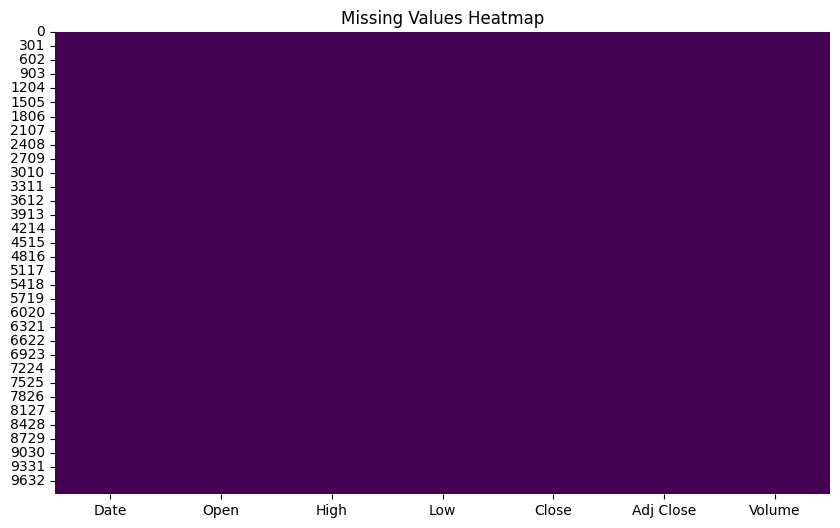

In [26]:
# Missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Plotting missing values as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


The heatmap and the `isna()` function confirm the absence of missing values in the dataset, eliminating the need for data imputation.

#### Histogram Analysis

Histogram analysis is implemented to gain a deeper understanding of the distribution of numerical features within the dataset. It provides a visual representation of how data points are spread across different ranges, allowing for the identification of patterns, anomalies, and potential outliers. For financial datasets, such as stock prices and trading volumes, this analysis is particularly useful for recognizing skewness, which is common due to the presence of extreme values or outliers.

By observing these distributions, I can make informed decisions about preprocessing steps, such as whether to apply scaling methods (e.g., Min-Max scaling or Standardization) or transformations (e.g., log transformations) to normalize the data. This ensures that features are appropriately prepared for machine learning models, which often perform better when input data is scaled or follows a more uniform distribution. Additionally, histogram analysis helps to highlight features that may require special attention, such as those with a high variance or significant skewness, guiding a targeted and efficient preprocessing strategy.

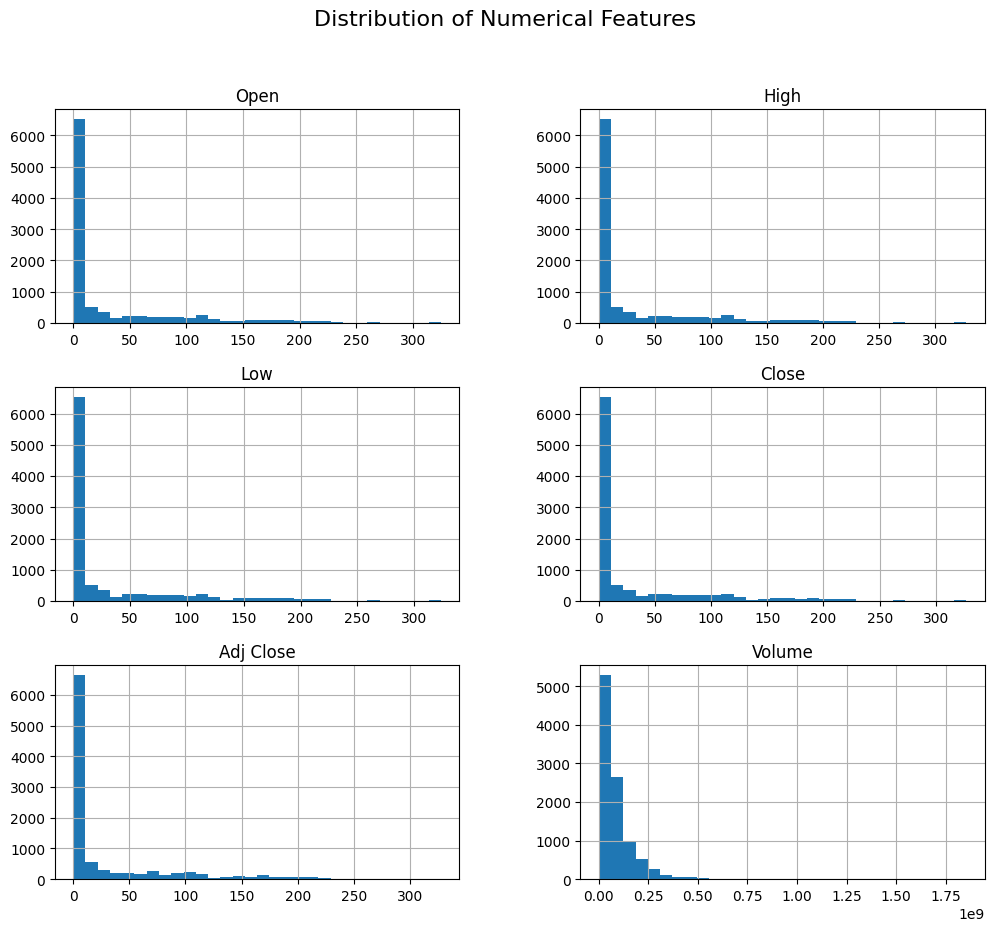

In [27]:
# Plotting histograms for numerical columns
data.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


The heatmap and the `isna()` function confirm the absence of missing values in the dataset, eliminating the need for data imputation.

The histograms for the numerical features (`Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`) in the **AAPL stock dataset** clearly demonstrate **right-skewed distributions**, a common characteristic in financial data. Most values are concentrated at the lower end, while a smaller number of extreme outliers extend toward higher ranges. [15]

For the `Open`, `High`, `Low`, `Close`, and `Adj Close` features, this skewness suggests the need for  scaling techniques such as **Min-Max Scaling**. This would help me normalize the data, reducing the influence of outliers and ensuring features are on a scale suitable for machine learning models. The **Volume** feature, in particular, exhibits extreme skewness and a significantly larger scale compared to the price-related features. Applying a **log transformation** to `Volume` would compress the range and mitigate the variability without distorting the feature's inherent patterns.

Additionally, the right-skewed nature of these distributions indicates that outliers—potentially caused by market anomalies, such as earnings reports or macroeconomic events—require careful handling. Outlier detection methods can help determine whether these spikes reflect meaningful trends or noise. Since price features are interrelated, **correlation analysis** is necessary to identify redundancy or multicollinearity. 


#### Correlation Analysis

The correlation heatmap is implemented so that I can understand the linear relationships between numerical features in the dataset, such as Open, Close, High, Low, and Volume. This visualization helps identify highly correlated features, which may introduce redundancy, and weakly correlated features, which could provide independent value to predictive models which is what I felt was neseccary to understand multicolinearity 

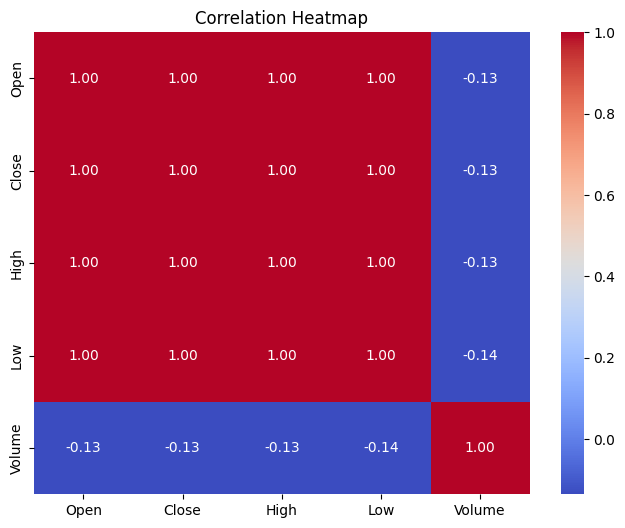

In [28]:
# Correlation matrix
correlation = data[['Open', 'Close', 'High', 'Low', 'Volume']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


The correlation heatmap reveals a perfect positive correlation among the price-related features (Open, High, Low, Close, and Adj Close). While this indicates redundancy, these features cannot be arbitrarily dropped in the context of ARIMA and multi-step regression. Since these models rely on the temporal relationships and trends across multiple price points, removing any feature could lead to a loss of critical information.

To address this, I will retain all price-related features and implement Min-Max Scaling to normalize them to a consistent range. This ensures that each feature contributes proportionately to the models without being dominated by larger numerical values. For the Volume feature, which exhibits extreme skewness and operates on a significantly different scale, I will apply a log transformation to compress its range and reduce variability while preserving its inherent structur

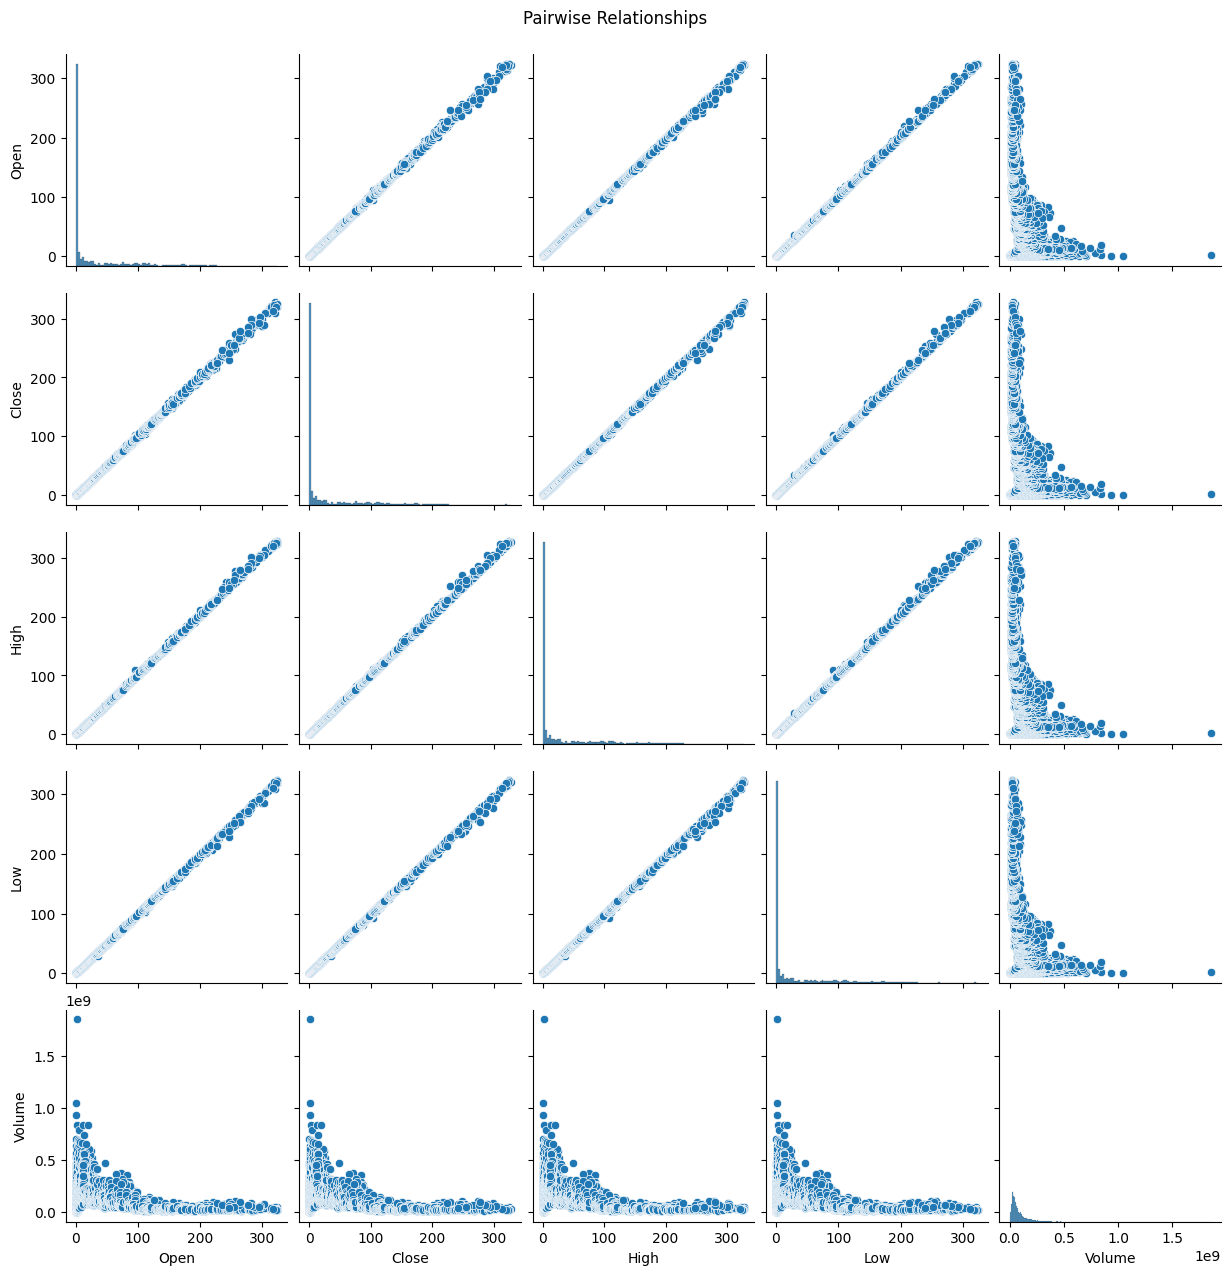

In [29]:
# Pairplot to show pairwise relationships
sns.pairplot(data[['Open', 'Close', 'High', 'Low', 'Volume']])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


I implemented the **pairplot** to visualize the pairwise relationships between the numerical features in the dataset (`Open`, `Close`, `High`, `Low`, and `Volume`). This visualization helps uncover patterns, trends, and relationships while assessing the linearity or independence between features.

The pairplot confirms the **strong linear relationships** among the price features (`Open`, `Close`, `High`, `Low`), which is expected as they are derived from the same stock price behavior over the trading day. This reinforces the earlier findings from the correlation heatmap, highlighting the interdependence of these features.

In contrast, the `Volume` feature exhibits a **more dispersed and nonlinear relationship** with the price features, suggesting that it varies independently and captures unique aspects of market activity, such as trading intensity or liquidity. This insight is particularly valuable for guiding preprocessing decisions. Instead of dropping any features due to correlation, I will stick to the strategy of retaining all of them and apply **Min-Max Scaling** to the price features for normalization. Additionally, I will perform a **log transformation** on `Volume` to address its skewness and ensure it contributes meaningfully to the analysis.


#### Time Series Plot

This time-series plot is important for understanding the temporal trends of key stock metrics, specifically the Close Price and Volume. It helps identify patterns, such as upward or downward trends, volatility, and periods of high trading activity. Such insights are essential for forecasting, as they allow us to pinpoint significant events or anomalies and understand how stock prices and trading volumes interact over time.I implemented it using  the article "What is time series plot and how you can create one ?"[8]

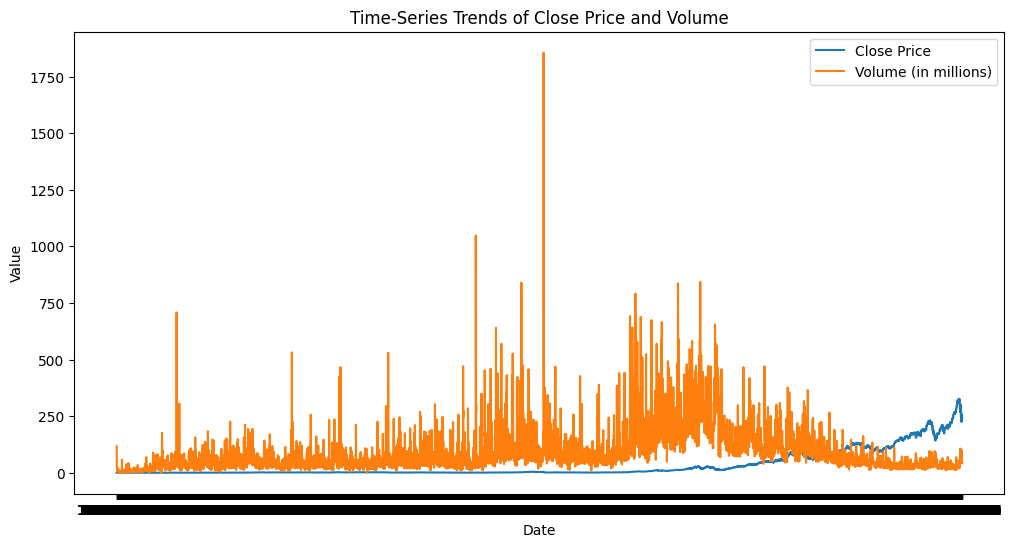

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['Volume'] / 1e6, label='Volume (in millions)')
plt.legend()
plt.title("Time-Series Trends of Close Price and Volume")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


The time-series plot reveals a clear upward trend in **Close Price** with increasing volatility and high variability in **Volume**, marked by extreme spikes. For preprocessing, I will address these patterns by ensuring **stationarity** in `Close Price` using **differencing**, a critical step for ARIMA models. Simultaneously, I will apply a **log transformation** to `Volume` to manage its scale and reduce the impact of extreme values while retaining variability. Additionally, **Min-Max Scaling** will be applied to normalize the price-related features (`Open`, `High`, `Low`, `Close`, `Adj Close`), ensuring they contribute proportionately to regression models. These preprocessing steps collectively prepare the data for robust time-series modeling, preserving both temporal trends and feature relationships.

#### Gathering Additional Insights About the Stock Being Evaluated

The metadata file provides essential contextual information about the stocks in the dataset, including their names, market categories, and whether they are classified as ETFs. This information is crucial for understanding the broader context of the stock data and enables filtering or grouping based on specific attributes, such as market sector or stock type.

Retriving the data for the stock AAPL

In [31]:
meta_path = r"D:\Master Things\Fall Sem Classes\Intro to Machine Learning\Homework\Project Submission\Project Notebooks\symbols_valid_meta.csv"


# Load the metadata
metadata = pd.read_csv(meta_path)
symbol = 'AAPL'
stock_info = metadata[metadata['Symbol'] == symbol]

# Display the metadata for AAPL in a better format
if not stock_info.empty:
    print(f"Metadata for {symbol}:")
    display(stock_info.style.set_caption(f"Metadata for {symbol}"))
else:
    print(f"No metadata found for symbol: {symbol}")


Metadata for AAPL:


,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
12,Y,AAPL,Apple Inc. - Common Stock,Q,Q,N,100.000000,N,N,nan,AAPL,N


The metadata confirms that the dataset pertains to **Apple Inc. (`AAPL`)**, a NASDAQ-listed stock categorized under standard equities, with a round lot size of **100 shares**. This information highlights that Apple is a highly liquid, widely traded large-cap stock, where spikes in `Volume` are likely influenced by institutional trading or major events, such as product launches or earnings reports. The `ETF` status marked as "N" ensures the analysis focuses on individual stock behavior rather than fund dynamics. Additionally, the round lot size provides insights into trading patterns, where large trades might signal institutional activity. Understanding this context is crucial for interpreting anomalies in volume trends and price movements accurately, especially when performing time-series modeling. This reference was gained using ChatGPT.

I am not directly using the metadata in the this  notebook, but it is still important to mention as it provides essential context about the stock, such as its market category, listing exchange, and whether it is an ETF. Metadata like this is static and does not change over time.

### Data Preprocessing

#### Sorting and Deduplicdication

I implemented **sorting** and **deduplication** to ensure the integrity and temporal accuracy of my dataset, which is critical for both **ARIMA** and **regression** methods. For ARIMA, maintaining the sequential nature of time-series data is essential for capturing patterns like trends and seasonality. Sorting the data by `Date` preserves this temporal order, while removing duplicates prevents disruptions in continuity that could bias parameter estimation or invalidate stationarity checks. In regression tasks, features such as **lagged values**, **rolling statistics**, and **multi-step targets** rely on a well-ordered dataset. Without proper sorting, these features could misalign, leading to invalid inputs for the model. Additionally, duplicates may introduce redundancy, increase the risk of overfitting, and distort the train-test split, which must strictly follow temporal order to replicate real-world forecasting conditions. By ensuring proper sorting and deduplication, I prepared a clean, consistent dataset that supports accurate and reliable predictions.

In [32]:
# Ensuring the index is in datetime format
data.index = pd.to_datetime(data.index, errors='coerce')

# Droping rows with invalid dates, if any
data = data[~data.index.isna()]

# Sorting the data by the datetime index
data = data.sort_index()

# Removing duplicate rows based on the index (Date)
data = data[~data.index.duplicated(keep='first')]

# Verifying the processed data
print("Processed data:")
print(data.head())


Processed data:
                                     Date      Open      High       Low  \
1970-01-01 00:00:00.000000000  1980-12-12  0.513393  0.515625  0.513393   
1970-01-01 00:00:00.000000001  1980-12-15  0.488839  0.488839  0.486607   
1970-01-01 00:00:00.000000002  1980-12-16  0.453125  0.453125  0.450893   
1970-01-01 00:00:00.000000003  1980-12-17  0.462054  0.464286  0.462054   
1970-01-01 00:00:00.000000004  1980-12-18  0.475446  0.477679  0.475446   

                                  Close  Adj Close     Volume  
1970-01-01 00:00:00.000000000  0.513393   0.406782  117258400  
1970-01-01 00:00:00.000000001  0.486607   0.385558   43971200  
1970-01-01 00:00:00.000000002  0.450893   0.357260   26432000  
1970-01-01 00:00:00.000000003  0.462054   0.366103   21610400  
1970-01-01 00:00:00.000000004  0.475446   0.376715   18362400  


errors='coerce': Converts any invalid or unparseable date strings into NaT (Not a Time), which represents missing or null datetime values in pandas. This ensures that the conversion process doesn't fail due to bad data but instead flags problematic entries.

#### Min Max Scaling

In [33]:

# Initializing MinMaxScaler
scaler = MinMaxScaler()

# Applying Min-Max Scaling to all columns except 'Volume'
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Verifying the scaled data
print("\nMin-Max Scaled Data:")
print(data.head())



Min-Max Scaled Data:
                                     Date      Open      High       Low  \
1970-01-01 00:00:00.000000000  1980-12-12  0.000970  0.000967  0.000981   
1970-01-01 00:00:00.000000001  1980-12-15  0.000894  0.000886  0.000898   
1970-01-01 00:00:00.000000002  1980-12-16  0.000784  0.000777  0.000787   
1970-01-01 00:00:00.000000003  1980-12-17  0.000812  0.000811  0.000822   
1970-01-01 00:00:00.000000004  1980-12-18  0.000853  0.000852  0.000863   

                                  Close  Adj Close     Volume  
1970-01-01 00:00:00.000000000  0.000969   0.000768  117258400  
1970-01-01 00:00:00.000000001  0.000887   0.000703   43971200  
1970-01-01 00:00:00.000000002  0.000778   0.000616   26432000  
1970-01-01 00:00:00.000000003  0.000812   0.000644   21610400  
1970-01-01 00:00:00.000000004  0.000853   0.000676   18362400  


The Min-Max Scaling was essential in this dataset to normalize the price-related features (Open, High, Low, Close, and Adj Close) and bring them into a consistent range, ensuring they contribute proportionately to the machine learning models. The histogram analysis revealed that these features, while not as skewed as Volume, had different scales and ranges, which could lead to imbalanced contributions during model training. The pair plot and correlation matrix further confirmed strong linear relationships between the price features, indicating redundancy but also highlighting their interdependence. Without scaling, the larger magnitude of one feature, such as High or Close, could dominate the model’s learning process, leading to biased predictions. Min-Max Scaling compresses all values into the range [0, 1], preserving their relative relationships while making the dataset suitable for algorithms sensitive to feature scales, such as Random Forest and regression models. This ensures a level playing field across all price features and aligns their scales with the log-transformed Volume, resulting in a well-balanced and harmonized dataset for forecasting.

#### Log Transformation

In [34]:
# Applying log transformation to the 'Volume' column
data['Volume'] = np.log1p(data['Volume'])  # log1p ensures log(1 + x) to handle zero values safely

# Verifying the log-transformed volume
print("\nLog-Transformed Volume:")
print(data[['Volume']].head())



Log-Transformed Volume:
                                  Volume
1970-01-01 00:00:00.000000000  18.579891
1970-01-01 00:00:00.000000001  17.599045
1970-01-01 00:00:00.000000002  17.090086
1970-01-01 00:00:00.000000003  16.888685
1970-01-01 00:00:00.000000004  16.725816


The **log transformation** on the `Volume` column was crucial to address the extreme skewness and scale identified during the exploratory data analysis. The histogram for `Volume` revealed a highly skewed distribution, with most values concentrated at lower ranges and a few extreme outliers dominating the upper end, which could disrupt model training by introducing bias. The correlation matrix further highlighted a weak and nonlinear relationship between `Volume` and price-related features (`Open`, `Close`, etc.), indicating its independence but also its potential to add noise if left unprocessed. Additionally, the pair plot confirmed that `Volume` exhibited a dispersed and nonlinear pattern with price features, making it difficult to interpret or leverage effectively for predictive modeling. The log transformation compresses extreme values, stabilizing variance and aligning `Volume` with other scaled features, such as those normalized using Min-Max scaling. This transformation not only improves the interpretability of `Volume` in relation to price features but also ensures a more balanced dataset for regression and time-series forecasting tasks, preventing outliers from disproportionately influencing the model.

#### Staitionary Check  and Differencing for ARIMA Model

In time-series analysis, a dataset is considered **stationary** if its statistical properties, such as mean, variance, and autocorrelation, remain constant over time [1]. Stationarity is a critical assumption for many forecasting models, including ARIMA, as these models rely on consistent patterns to predict future values. Non-stationary data, characterized by trends, seasonality, or changing variance, can lead to inaccurate model estimations, as the underlying statistical structure may change over time [2]. To assess stationarity, methods like the **Augmented Dickey-Fuller (ADF) test** are widely used.

The **ADF test** is a statistical test designed to assess whether a time series is stationary. It does this by evaluating the null hypothesis, which states that the data has a unit root (indicating non-stationarity) [3]. If the p-value of the test is high (e.g., > 0.05), it suggests failing to reject the null hypothesis, indicating non-stationarity. Conversely, a low p-value (e.g., < 0.05) means rejecting the null hypothesis and confirms that the series is stationary. By performing the ADF test, we determine if transformations like differencing or detrending are needed to stabilize the dataset.

In the context of **ARIMA**, stationarity is fundamental because the model assumes that the statistical properties of the data remain constant over time. Without stationarity, ARIMA cannot effectively capture or predict patterns such as trends or seasonality. For **regression models**, stationarity ensures that temporal features, such as lagged values or rolling statistics, maintain consistent relationships with the target variable, enabling the model to learn and generalize effectively. By implementing stationarity checks and applying necessary transformations, I ensure the dataset is robust and suitable for accurate forecasting.


In [35]:
adf_result = adfuller(data['Close'])
print("\nADF Test Result:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Test Result:
ADF Statistic: 1.8939738468259164
p-value: 0.998518261884598


The Augmented Dickey-Fuller (ADF) test result reveals an ADF statistic of 1.89 and a p-value of 0.9985, indicating that we fail to reject the null hypothesis and conclude that the Close series is non-stationary. This suggests the presence of trends or seasonality in the data that must be addressed before applying ARIMA. 

**Differencing** is a transformation technique used in time-series analysis to stabilize the mean and remove trends or seasonality from non-stationary data [4]. It involves calculating the differences between consecutive observations, effectively eliminating long-term dependencies and making the series more stationary. For example, first-order differencing subtracts the value at time \( t-1 \) from the value at time \( t \), producing a new series of differences. Higher-order differencing can be applied if first-order differencing does not sufficiently address the non-stationarity.

The **Augmented Dickey-Fuller (ADF) test** result revealed an ADF statistic of 1.89 and a p-value of 0.9985, indicating that we fail to reject the null hypothesis and conclude that the `Close` series is non-stationary. This non-stationarity suggests the presence of trends or seasonality in the data, which can bias models like ARIMA that assume stationarity. To address this, I implemented **first-order differencing** on the `Close` series, transforming it into a stationary series by removing the trend component. This ensures the ARIMA model can focus on capturing meaningful patterns, such as seasonality or autocorrelation, rather than being misled by long-term trends.

Differencing was also crucial for creating reliable lag and rolling features for regression models. By stabilizing the mean and removing dependencies, differencing allowed these temporal features to maintain consistent relationships with the target variable, ensuring that regression models could effectively learn from the data.



Applied differencing to make the series stationary.


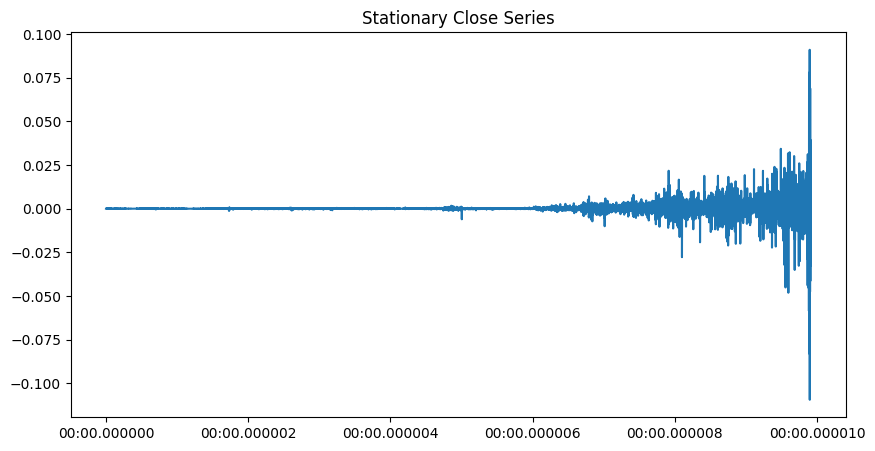

In [36]:

if adf_result[1] > 0.05: 
    data['Close_Stationary'] = data['Close'].diff().dropna()
    print("\nApplied differencing to make the series stationary.")
else:
    data['Close_Stationary'] = data['Close']

# Plot the stationary series
plt.figure(figsize=(10, 5))
plt.plot(data['Close_Stationary'])
plt.title("Stationary Close Series")
plt.show()


This plot confirms that the Close series has been transformed into a stationary series, allowing ARIMA to focus on capturing meaningful patterns like autocorrelation. The increasing volatility over time will require careful handling to ensure the robustness of the model's predictions.

#### Checking for Outliers using IQR

The Interquartile Range (IQR) is a statistical measure that represents the middle 50% of a dataset, calculated as the difference between the third quartile (Q3) and the first quartile (Q1). It is a robust method for detecting outliers because it focuses on the spread of the central portion of the data while ignoring extreme values. Outliers are typically identified as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR [5]. In the context of my dataset, where features such as Close and Volume exhibit skewed distributions (as revealed through histogram analysis), IQR is particularly useful for detecting anomalies without being influenced by the skewness.

In [37]:
# Define a function to cap outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

# Cap outliers in relevant columns
data['Close'] = cap_outliers(data['Close'])
data['Volume'] = cap_outliers(data['Volume'])

# Verify the absence of extreme outliers
print("\nCapped Close Feature:")
print(data['Close'].describe())
print("\nCapped Volume Feature:")
print(data['Volume'].describe())



Capped Close Feature:
count    9909.000000
mean        0.068504
std         0.102472
min         0.000000
25%         0.002676
50%         0.004696
75%         0.108760
max         0.267887
Name: Close, dtype: float64

Capped Volume Feature:
count    9909.000000
mean       17.897626
std         0.867246
min        15.550750
25%        17.313299
50%        17.870159
75%        18.488332
max        20.250881
Name: Volume, dtype: float64


**Capping** is a technique that limits extreme values within a specified range by replacing outliers with the upper or lower bounds, calculated using methods like the IQR. Here, I am capping outliers instead of removing them because it retains all data points while reducing the influence of extreme values, ensuring no loss of information, which is particularly important in financial datasets where outliers may reflect meaningful market events. As noted, capping ensures that the dataset remains intact while reducing the impact of outliers on model predictions [5].

### Feature extraction and Feature Engineering

#### Creating Lag Features

Creating **lag features** is essential for capturing the temporal dependencies in time-series data, where past values of a variable influence its future behavior. By generating lag features, such as `Close_Lag_1` to `Close_Lag_5`, I incorporate the historical `Close` prices from the previous five days as predictors, allowing models to learn patterns and relationships over time.

In the context of **regression models**, lag features help the model establish a relationship between past `Close` prices and future target values (e.g., `Close_t+1`). These features are particularly valuable for identifying trends, momentum, or reversal points, which are critical in forecasting stock prices.

For **ARIMA models**, lagged values directly feed into the autoregressive component, which predicts the current value of the time series based on its prior values. Including these lag features ensures the model captures autocorrelation within the data, enabling it to generate more accurate predictions. Without lag features, models would lack the historical context necessary for time-series forecasting, limiting their predictive power.

In [38]:
# Generating lag features
for lag in range(1, 6):  
    data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)

print("\nData with Lag Features:")
print(data[['Close', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5']].head(10))



Data with Lag Features:
                                  Close  Close_Lag_1  Close_Lag_2  \
1970-01-01 00:00:00.000000000  0.000969          NaN          NaN   
1970-01-01 00:00:00.000000001  0.000887     0.000969          NaN   
1970-01-01 00:00:00.000000002  0.000778     0.000887     0.000969   
1970-01-01 00:00:00.000000003  0.000812     0.000778     0.000887   
1970-01-01 00:00:00.000000004  0.000853     0.000812     0.000778   
1970-01-01 00:00:00.000000005  0.000942     0.000853     0.000812   
1970-01-01 00:00:00.000000006  0.001017     0.000942     0.000853   
1970-01-01 00:00:00.000000007  0.001085     0.001017     0.000942   
1970-01-01 00:00:00.000000008  0.001174     0.001085     0.001017   
1970-01-01 00:00:00.000000009  0.001338     0.001174     0.001085   

                               Close_Lag_3  Close_Lag_4  Close_Lag_5  
1970-01-01 00:00:00.000000000          NaN          NaN          NaN  
1970-01-01 00:00:00.000000001          NaN          NaN          NaN  
19

#### Creating Rolling Means 

In [39]:
# Creating rolling statistics
data['Rolling_Mean_7'] = data['Close'].rolling(window=7).mean()
data['Rolling_Std_7'] = data['Close'].rolling(window=7).std()

**Rolling means** (or moving averages) smooth out short-term fluctuations by calculating the average of the `Close` prices over a specified window, such as 7 days. This highlights long-term trends while filtering out daily volatility, making it easier to detect patterns in stock price movements. Creating rolling means serves as a feature for regression models, capturing recent momentum or stability in the `Close` price to improve predictions. Paired with rolling standard deviations, they also provide insights into market volatility, ensuring the model can learn from both trend and variability in the data.

#### RSI (Relative Strength Index)

In [40]:
# Creating technical indicators (Relative Strength Index - RSI)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['Close'])

# Droping rows with NaN values introduced by feature engineering
data = data.dropna()

# Verifying the dataset
print("\nFeature-Engineered Data Sample:")
print(data.head())


Feature-Engineered Data Sample:
                                     Date      Open      High       Low  \
1970-01-01 00:00:00.000000013  1981-01-02  0.001286  0.001288  0.001299   
1970-01-01 00:00:00.000000014  1981-01-05  0.001252  0.001240  0.001257   
1970-01-01 00:00:00.000000015  1981-01-06  0.001169  0.001158  0.001174   
1970-01-01 00:00:00.000000016  1981-01-07  0.001094  0.001083  0.001098   
1970-01-01 00:00:00.000000017  1981-01-08  0.001059  0.001049  0.001064   

                                  Close  Adj Close     Volume  \
1970-01-01 00:00:00.000000013  0.001283   0.001017  15.550750   
1970-01-01 00:00:00.000000014  0.001242   0.000984  16.005151   
1970-01-01 00:00:00.000000015  0.001160   0.000919  16.239393   
1970-01-01 00:00:00.000000016  0.001085   0.000860  16.448952   
1970-01-01 00:00:00.000000017  0.001051   0.000833  16.113766   

                               Close_Stationary  Close_Lag_1  Close_Lag_2  \
1970-01-01 00:00:00.000000013          0.000020 

The **Relative Strength Index (RSI)** is a widely used technical indicator designed to measure the momentum of stock prices on a scale from 0 to 100. An RSI value above 70 indicates that the stock may be in **overbought conditions**, suggesting a potential price decline as the stock is considered overvalued. Conversely, an RSI below 30 signals **oversold conditions**, pointing to a possible price increase as the stock may be undervalued. By identifying these extremes, RSI provides critical insights into the likelihood of trend reversals and momentum shifts, making it an essential feature for regression models that aim to predict future price movements. Including RSI helps the model capture momentum trends and potential reversal signals, which are key in short-term forecasting [6].

Calculating RSI involves rolling computations of average gains and losses over a given period (typically 14 days), which inherently introduces missing values (`NaN`) in the initial rows where sufficient past data is unavailable. These missing rows are removed during preprocessing to ensure the dataset remains clean, consistent, and aligned for effective model training. This step guarantees that the regression models leverage a complete dataset, free from inconsistencies that could impair their ability to learn meaningful relationships.

### Model Creation

#### Random Forest Regression

The **Random Forest Regressor** is an ensemble learning method that builds multiple decision trees and combines their outputs to provide robust and accurate predictions. It works by averaging the results of individual decision trees trained on random subsets of the data, which reduces overfitting and enhances generalization. Unlike linear models, Random Forest does not assume any specific data distribution, making it well-suited for complex, non-linear relationships often observed in stock market data [7,8].  

For this temporal stock market dataset, I chose **Random Forest Regressor** because of its ability to handle large feature spaces, such as lag features, rolling statistics, and technical indicators like RSI, without being significantly affected by multicollinearity. As discussed in [1], Random Forest can capture patterns across time by incorporating lagged values as input features, making it highly effective for short-term time series forecasting. Additionally, its resilience to outliers, combined with its capacity to handle non-linear dependencies, aligns well with the volatility and irregularities seen in financial data. The model’s interpretability and flexibility further make it a practical choice for generating accurate forecasts while assessing the importance of different features.

In [41]:
steps = 3  # Number of steps ahead for targets
for step in range(1, steps + 1):
    data[f'Close_t+{step}'] = data['Close'].shift(-step)

# Drop rows with NaN values due to target generation
data = data.dropna()


I implemented the creation of multi-step targets to prepare the dataset for regression models that predict stock prices for the next few days. By shifting the `Close` column by 1, 2, or more steps into the future, I generated new target columns (e.g., `Close_t+1`, `Close_t+2`, `Close_t+3`) representing the stock price at these future time points. This approach allows the regression model to predict multiple time steps simultaneously, which is critical for multi-step forecasting tasks. After generating these target columns, I removed rows with `NaN` values introduced at the end of the dataset, ensuring the data remains clean and aligned for training. This preprocessing step enables the regression model to understand temporal patterns in stock prices and effectively predict future values.

The next two blocks are validation check for the changes made and also to set the target column and the feature column for the model

In [42]:
print("Columns in the dataset:", data.columns)
print("Sample of the dataset:")
print(data[[f'Close_t+{i}' for i in range(1, steps + 1)]].head())


Columns in the dataset: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close_Stationary', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3',
       'Close_Lag_4', 'Close_Lag_5', 'Rolling_Mean_7', 'Rolling_Std_7', 'RSI',
       'Close_t+1', 'Close_t+2', 'Close_t+3'],
      dtype='object')
Sample of the dataset:
                               Close_t+1  Close_t+2  Close_t+3
1970-01-01 00:00:00.000000013   0.001242   0.001160   0.001085
1970-01-01 00:00:00.000000014   0.001160   0.001085   0.001051
1970-01-01 00:00:00.000000015   0.001085   0.001051   0.001140
1970-01-01 00:00:00.000000016   0.001051   0.001140   0.001126
1970-01-01 00:00:00.000000017   0.001140   0.001126   0.001065


In [43]:
target_columns = [f'Close_t+{i}' for i in range(1, steps + 1) if f'Close_t+{i}' in data.columns]
print("Target columns:", target_columns)
feature_columns = [col for col in data.columns if 'Lag' in col or 'Rolling' in col or col == 'RSI']
print("Feature columns:", feature_columns)


Target columns: ['Close_t+1', 'Close_t+2', 'Close_t+3']
Feature columns: ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'Rolling_Mean_7', 'Rolling_Std_7', 'RSI']


The **outer loop** in this process performs **time series cross-validation** by splitting the data into multiple training-validation and test sets. For each outer fold, the model's performance is evaluated on the unseen test set to provide an estimate of its generalization ability. Within each outer fold, the **inner loop** uses `GridSearchCV` to perform hyperparameter tuning by splitting the training-validation set further into smaller folds. The inner loop identifies the best combination of hyperparameters (e.g., `max_depth`, `n_estimators`) that minimizes the negative Mean Squared Error (MSE) on the training-validation data. This nested approach ensures that hyperparameter tuning does not leak information from the test set, providing an unbiased evaluation of the model’s performance.

In [44]:
outer_tscv = TimeSeriesSplit(n_splits=5)


test_mse_scores, test_mae_scores, test_r2_scores = [], [], []

**Grid search** is a hyperparameter optimization technique that exhaustively evaluates all possible combinations of predefined hyperparameter values to identify the best-performing configuration [10]. For the **Random Forest Regressor**, we have defined values for hyperparameters such as `n_estimators` (number of trees), `max_depth` (maximum depth of the trees), `min_samples_split` (minimum samples required to split a node), and `min_samples_leaf` (minimum samples required for a leaf node). These hyperparameters directly influence the model's ability to capture complexity and prevent overfitting.

The chosen values balance the trade-off between performance and computational cost. For instance, `n_estimators` ranges from 100 to 300 to ensure sufficient tree diversity while maintaining manageable training time. `max_depth` values of 5, 10, and 15 were selected to test varying levels of tree complexity, with deeper trees potentially capturing more intricate patterns but risking overfitting. Similarly, `min_samples_split` and `min_samples_leaf` help control overfitting by restricting tree growth in cases of limited data. Using grid search ensures that all combinations of these hyperparameters are tested systematically, guaranteeing that the best configuration is identified based on the evaluation metric, such as Mean Squared Error (MSE) or R².


In [45]:

# Creating directories for storing results
os.makedirs("results/summary", exist_ok=True)
for fold in range(1, 6):  # Adjusting range based on the number of outer folds
    os.makedirs(f"results/fold_{fold}", exist_ok=True)

In [46]:
# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Looping through each outer split
for fold, (train_val_idx, test_idx) in enumerate(outer_tscv.split(data)):
    print(f"\nOuter Fold {fold + 1}")
    
    # Train-validation and test sets
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]
    
    # Separating features and targets for train-validation and test
    X_train_val = train_val_data[feature_columns]
    y_train_val = train_val_data[target_columns]
    X_test = test_data[feature_columns]
    y_test = test_data[[f'Close_t+{i}' for i in range(1, steps + 1)]].values
    
    # Defining the inner TimeSeriesSplit for hyperparameter tuning
    inner_tscv = TimeSeriesSplit(n_splits=3)
    
    # Initializing Random Forest and GridSearchCV
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=inner_tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    # Performing hyperparameter tuning
    grid_search.fit(X_train_val, y_train_val)
    # Save cross-validation results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results.to_csv(f"results/fold_{fold + 1}/cv_results.csv", index=False)

    # Saving best hyperparameters
    best_params = grid_search.best_params_
    with open(f"results/fold_{fold + 1}/best_params.json", "w") as f:
            json.dump(best_params, f)

    best_params = grid_search.best_params_
    print("  Best Parameters:", best_params)
    
    # Training the final model with the best hyperparameters on train-validation set
    final_model = RandomForestRegressor(**best_params, random_state=42)
    final_model.fit(X_train_val, y_train_val)
    with open(f"results/fold_{fold + 1}/best_model.pkl", "wb") as f:
        pickle.dump(final_model, f)

    # Predicting on the test set
    y_test_pred = final_model.predict(X_test)
    y_test_pred = y_test_pred.reshape(-1, steps)  
    # Save test set predictions and actual values
    np.save(f"results/fold_{fold + 1}/test_predictions.npy", y_test_pred)
    np.save(f"results/fold_{fold + 1}/test_actuals.npy", y_test)

    
    # Evaluating on the test set
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    # Saving metrics for the fold
    fold_metrics = {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
    with open(f"results/fold_{fold + 1}/metrics.json", "w") as f:
        json.dump(fold_metrics, f)

    

    
    # Storing test set results
    test_mse_scores.append(mse)
    test_mae_scores.append(mae)
    test_r2_scores.append(r2)
    
    # Print test set results for the current fold
    print(f"  Test MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")



Outer Fold 1
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
  Test MSE: 0.0000, MAE: 0.0015, R2: -1.3103

Outer Fold 2
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
  Test MSE: 0.0000, MAE: 0.0002, R2: 0.9751

Outer Fold 3
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
  Test MSE: 0.0000, MAE: 0.0009, R2: 0.6448

Outer Fold 4
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
  Test MSE: 0.0008, MAE: 0.0189, R2: -0.3922

Outer Fold 5
Fitting 3 folds for each of 108 candidates, totalling 324 fits
  Best P

In [47]:
# Aggregate metrics across all folds
summary_metrics = {
    "mean_mse": np.mean(test_mse_scores),
    "std_mse": np.std(test_mse_scores),
    "mean_mae": np.mean(test_mae_scores),
    "std_mae": np.std(test_mae_scores),
    "mean_r2": np.mean(test_r2_scores),
    "std_r2": np.std(test_r2_scores)
}

# Save overall summary
with open("results/summary/overall_metrics.json", "w") as f:
    json.dump(summary_metrics, f)

# Print summary for reference
print("\nSummary of Test Set Results Across Folds:")
print(json.dumps(summary_metrics, indent=4))



Summary of Test Set Results Across Folds:
{
    "mean_mse": 0.0022365880100841187,
    "std_mse": 0.004068982609630696,
    "mean_mae": 0.020337745861848874,
    "std_mae": 0.03078556586915733,
    "mean_r2": -0.23264447878596622,
    "std_r2": 0.9093335520069495
}


In [ ]:
# Collecting fold-specific results into a comparison summary
comparison_data = []

for fold in range(len(test_mse_scores)):
    with open(f"results/fold_{fold + 1}/metrics.json", "r") as f:
        fold_metrics = json.load(f)
    comparison_data.append({
        "fold": fold + 1,
        "mse": fold_metrics["mse"],
        "mae": fold_metrics["mae"],
        "r2": fold_metrics["r2"]
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv("results/summary/comparison_summary.csv", index=False)

# Printing comparison summary for quick reference
print("\nComparison Summary Across Folds:")
print(comparison_df)



Comparison Summary Across Folds:
   fold           mse       mae        r2
0     1  2.954501e-06  0.001454 -1.310318
1     2  5.165808e-08  0.000161  0.975053
2     3  3.487578e-06  0.000881  0.644843
3     4  8.270138e-04  0.018901 -0.392162
4     5  1.034943e-02  0.080291 -1.080638


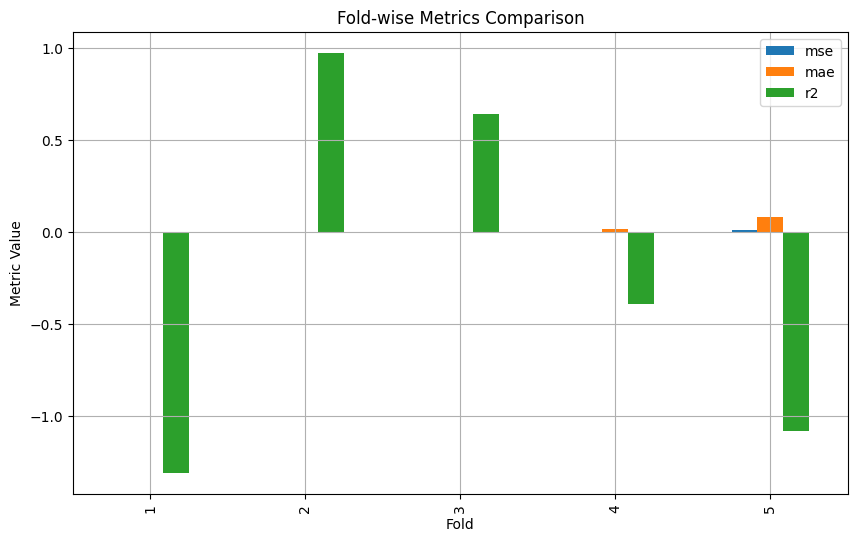

In [49]:
# Visualize comparison of fold-specific metrics
comparison_df = pd.read_csv("results/summary/comparison_summary.csv")

# Plot metrics comparison
comparison_df.plot(
    x="fold",
    y=["mse", "mae", "r2"],
    kind="bar",
    figsize=(10, 6),
    title="Fold-wise Metrics Comparison"
)
plt.ylabel("Metric Value")
plt.xlabel("Fold")
plt.grid()
plt.show()


The **best parameters** for each outer fold were determined using **Mean Squared Error (MSE)** as the evaluation metric during the inner cross-validation process conducted with `GridSearchCV`. For each fold, **GridSearchCV** systematically evaluates all 108 candidate parameter combinations across the training-validation split and identifies the configuration that minimizes the error. As explained in [9], `GridSearchCV` exhaustively tests parameter combinations, ensuring the best fit for the provided data, but the selected parameters may vary slightly across folds due to differences in the training-validation splits. This variability reflects how the model adapts to specific data characteristics, such as variance, trends, and stationarity. For instance, combinations like `'max_depth': None` and `'n_estimators': 300` facilitate deeper, more flexible models, which perform better in folds with more complex data, while constraints like `'max_depth': 10` and higher `min_samples_leaf` values enhance generalization in simpler or noisier data by reducing overfitting.

However, the overall negative **Mean R²** across the outer folds (-0.2326 ± 0.9093) highlights the Random Forest model's difficulty in generalizing across all test data. This issue arises because Random Forest models are not inherently designed to capture temporal dependencies in sequential data. The low or negative R² values observed in Folds 1, 4, and 5 suggest that while the selected parameters minimized errors locally (within the folds), the model struggled to handle unseen test data effectively, especially in the presence of trends or volatility. 

In [50]:
# Summary of test set results
print("\nTest Set Evaluation Summary:")
print(f"Mean MSE: {np.mean(test_mse_scores):.4f} ± {np.std(test_mse_scores):.4f}")
print(f"Mean MAE: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")
print(f"Mean R2: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")



Test Set Evaluation Summary:
Mean MSE: 0.0022 ± 0.0041
Mean MAE: 0.0203 ± 0.0308
Mean R2: -0.2326 ± 0.9093


#### Plotting the prediction of the random forrest regressor 

In [51]:
def inverse_transform_multi_step(y_scaled, scaler):
    y_original = np.zeros_like(y_scaled)
    for step in range(y_scaled.shape[1]):
        y_original[:, step] = scaler.inverse_transform(y_scaled[:, step].reshape(-1, 1)).flatten()
    return y_original
def plot_multi_step_predictions(y_test, y_test_pred, steps, title_prefix="Actual vs Predicted Prices"):
    time_indices = np.arange(len(y_test))  # Create clean x-axis indices
    for step in range(steps):
        plt.figure(figsize=(34, 6))
        
        # Plot actual values
        plt.plot(time_indices, y_test[:, step], label=f"Actual Prices (t+{step+1})", 
                 color="royalblue", linewidth=1, alpha=0.9)
        
        # Plot predicted values
        plt.plot(time_indices, y_test_pred[:, step], label=f"Predicted Prices (t+{step+1})", 
                 color="crimson", linestyle="--", linewidth=2.5, alpha=0.8)
        
        # Title and labels
        plt.title(f"{title_prefix} for t+{step+1}", fontsize=16, fontweight="bold", pad=15)
        plt.xlabel("Time Index", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        
        # Adding grid and legend
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend(loc="best", fontsize=12)
        
        # Adjust layout and show
        plt.tight_layout()
        plt.show()


I implemented the `inverse_transform_multi_step` function to convert the scaled predictions of the random forest regressor back to their original scale. Since the model operates on scaled data for better performance and numerical stability, it's essential to inverse-transform the outputs to ensure they are interpretable in the context of the original stock prices. This step is particularly critical in multi-step forecasting, as it allows me to compare predictions directly with the actual values and maintain consistency in evaluation across all forecasted time steps.

In [52]:


def plot_multi_step_error_distribution(y_test, y_test_pred, steps, title_prefix="Error Distribution"):
    for step in range(steps):
        errors = y_test[:, step] - y_test_pred[:, step]
        plt.figure(figsize=(12, 5))
        sns.histplot(errors, bins=40, kde=True, color="purple", alpha=0.8)
        plt.title(f"{title_prefix} for t+{step+1}", fontsize=14)
        plt.xlabel("Prediction Errors", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


I implemented this function to visually assess the accuracy and performance of the random forest regressor across multiple forecast horizons in my multi-step regression task. By plotting the actual and predicted values for each step, I can effectively evaluate how well the model captures the temporal patterns in stock prices and identify any degradation in prediction quality over time. This stepwise visualization not only helps me understand the model's performance but also provides clear insights into its predictive behavior, which is crucial for analyzing multi-step forecasts in time-series data.

In [53]:

def display_multi_step_prediction_summary(y_test, y_test_pred, steps):
    for step in range(steps):
        errors = y_test[:, step] - y_test_pred[:, step]
        summary_df = pd.DataFrame({
            f"Actual Prices (t+{step+1})": y_test[:, step],
            f"Predicted Prices (t+{step+1})": y_test_pred[:, step],
            f"Error (t+{step+1})": errors
        })
        print(f"\nSample Predictions and Errors for t+{step+1}:")
        print(summary_df.head(10))
        print(f"\nSummary Statistics for Errors for t+{step+1}:")
        print(summary_df[f"Error (t+{step+1})"].describe())


This is to display the summary of all the metrics for the Random Forest Regressor.

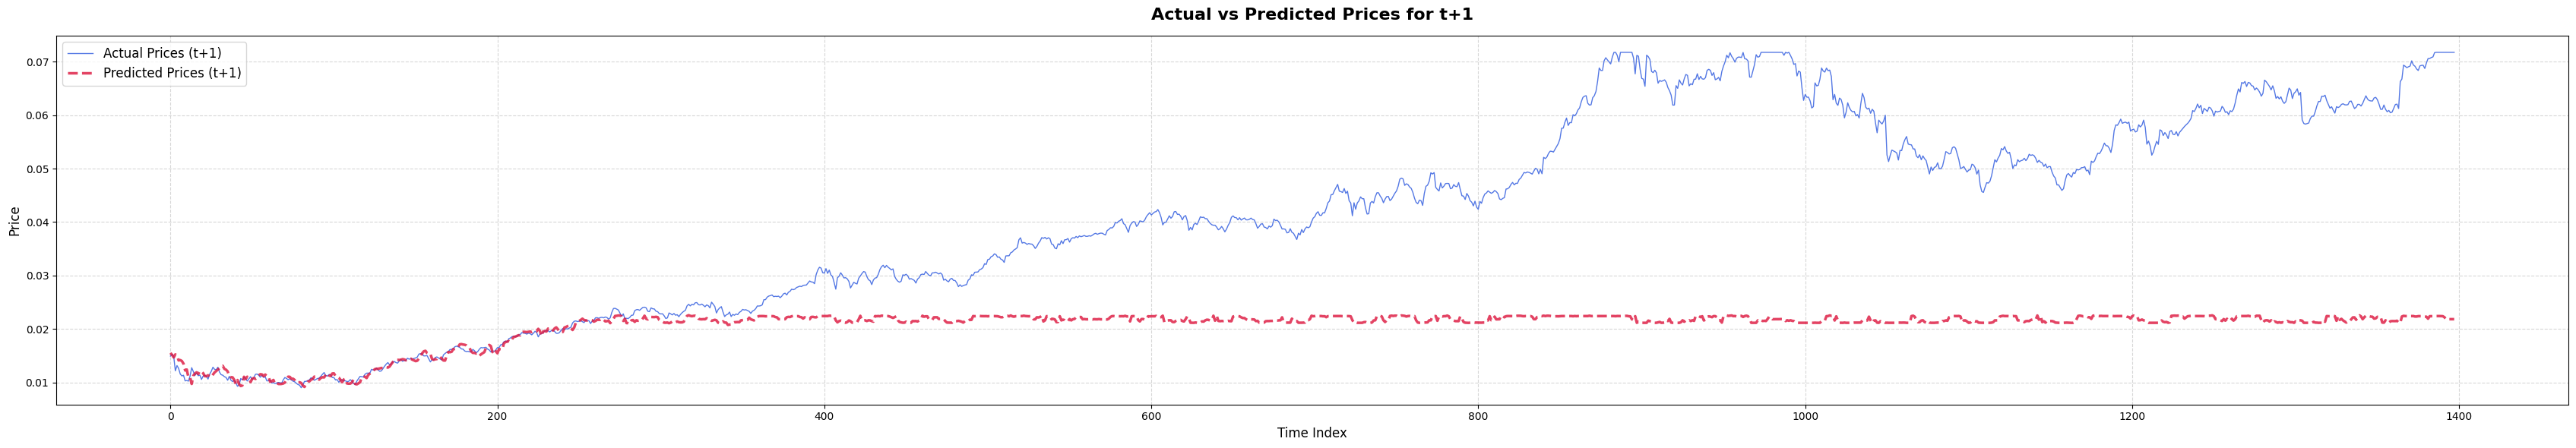

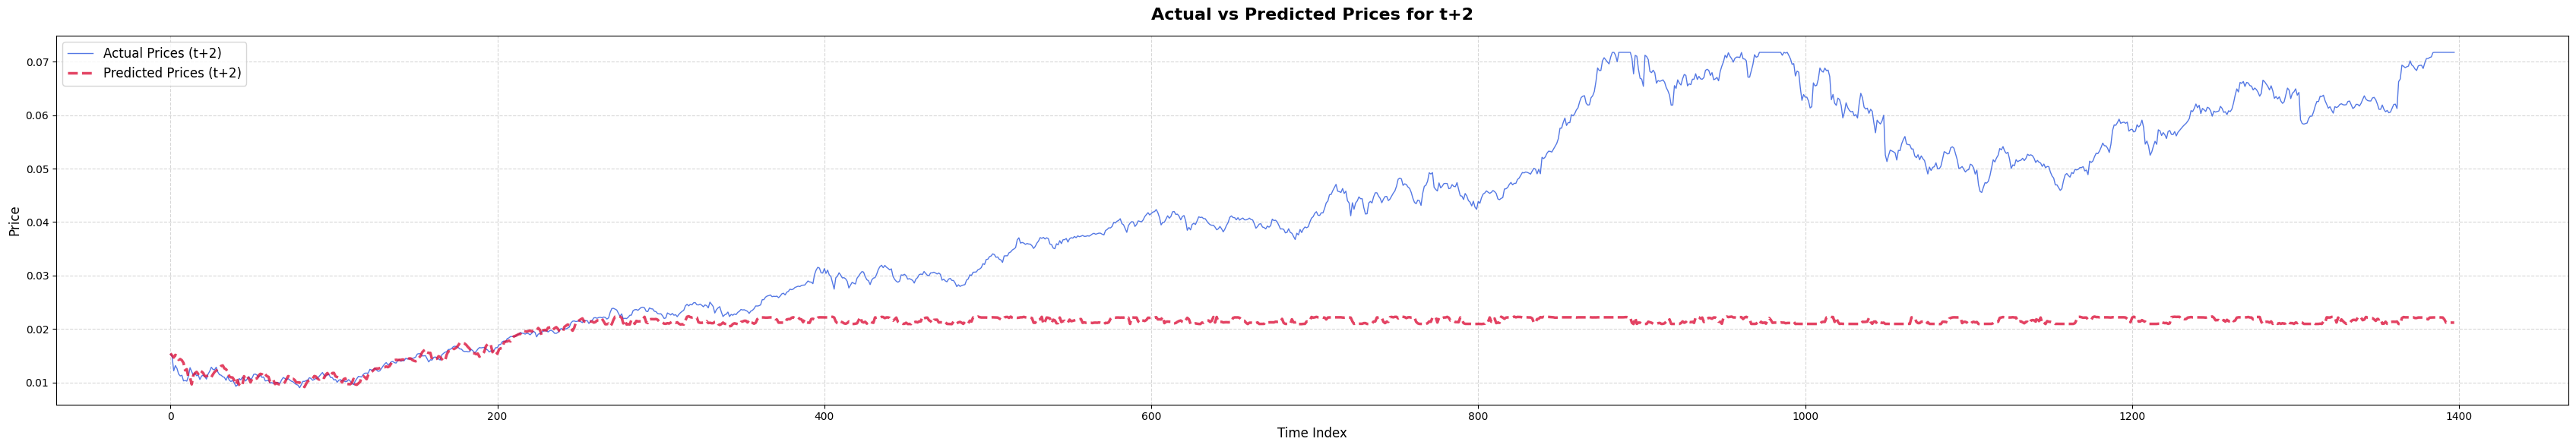

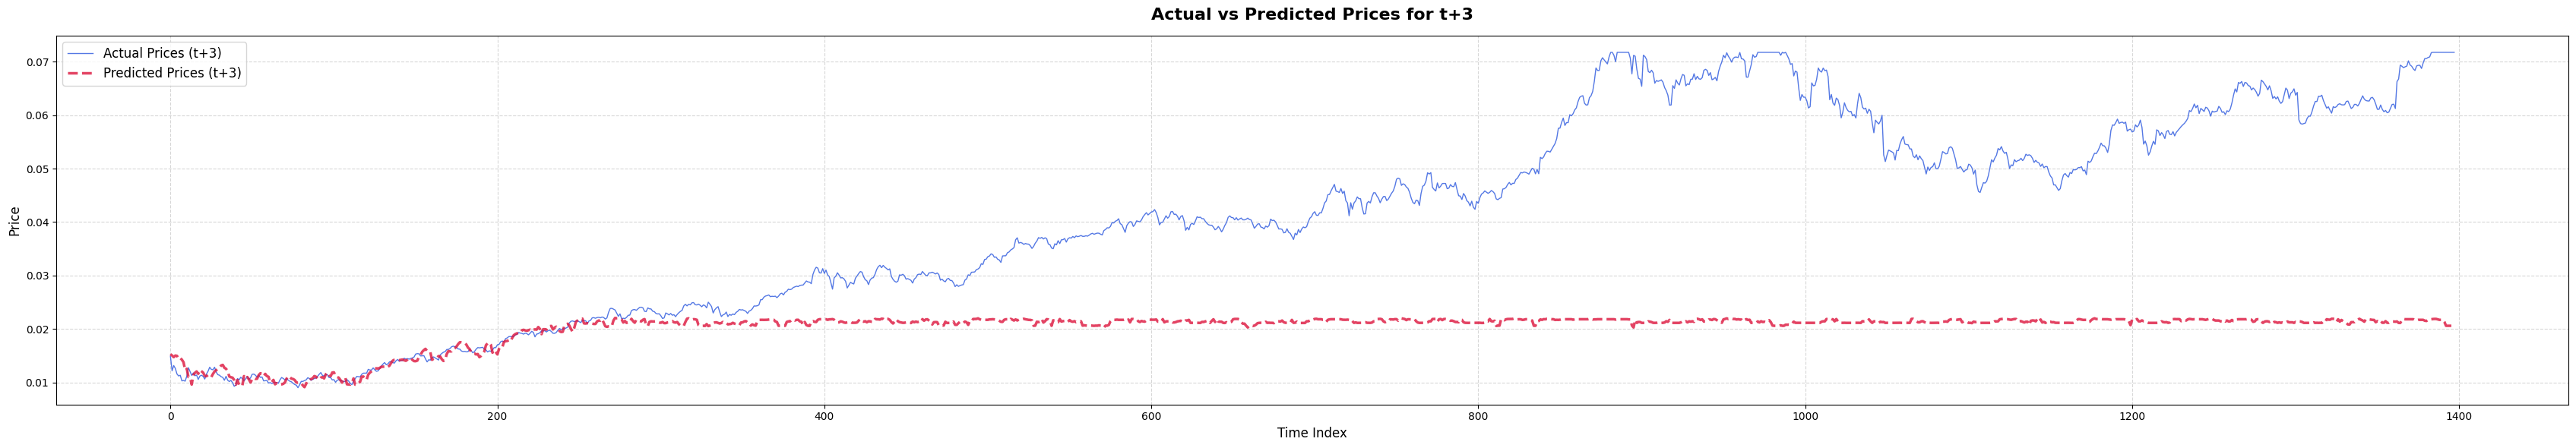

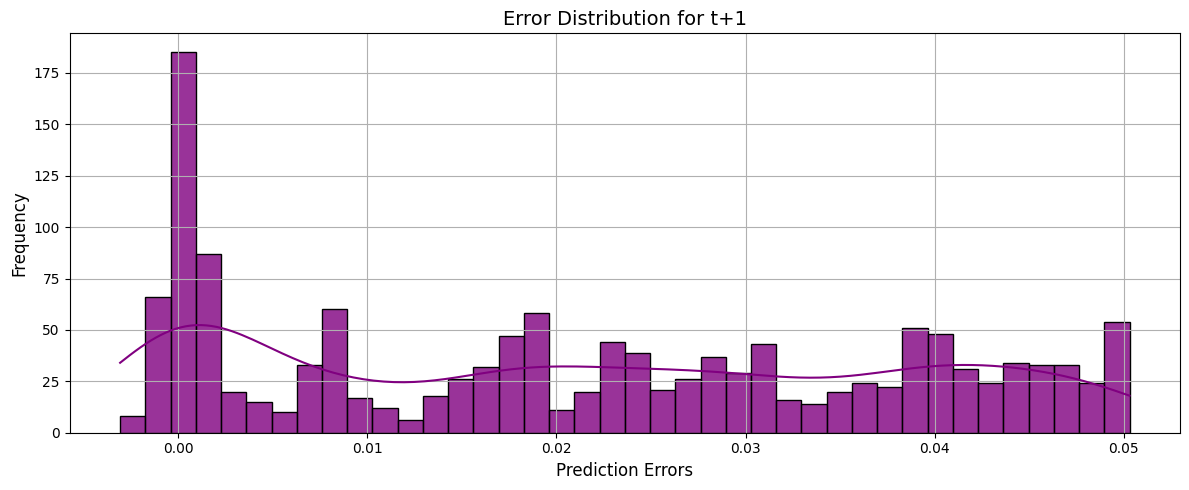

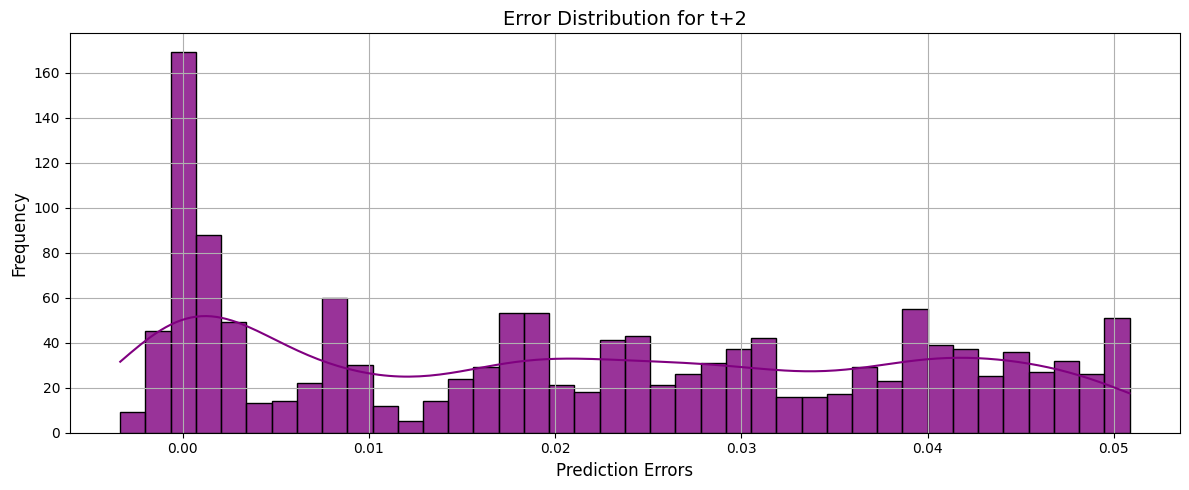

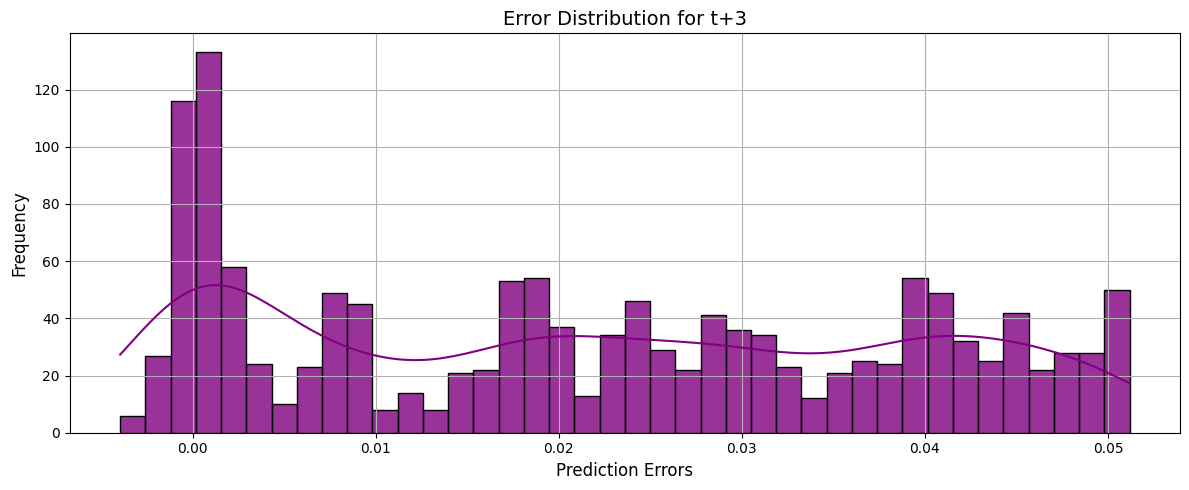


Sample Predictions and Errors for t+1:
   Actual Prices (t+1)  Predicted Prices (t+1)  Error (t+1)
0             0.014902                0.015507    -0.000605
1             0.015279                0.015136     0.000143
2             0.014847                0.014666     0.000181
3             0.012158                0.015226    -0.003068
4             0.013141                0.015011    -0.001870
5             0.012610                0.014107    -0.001498
6             0.011554                0.014167    -0.002613
7             0.011199                0.013986    -0.002787
8             0.011325                0.013488    -0.002163
9             0.010274                0.012230    -0.001956

Summary Statistics for Errors for t+1:
count    1398.000000
mean        0.021141
std         0.016873
min        -0.003068
25%         0.002451
50%         0.019563
75%         0.037218
max         0.050299
Name: Error (t+1), dtype: float64

Sample Predictions and Errors for t+2:
   Actual Prices (

In [54]:

scaler = MinMaxScaler()
training_data = data[['Close']]
scaler.fit(training_data)

y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

y_test_original = inverse_transform_multi_step(y_test, scaler)
y_test_pred_original = inverse_transform_multi_step(y_test_pred, scaler)

steps = y_test_pred.shape[1]
plot_multi_step_predictions(y_test_original, y_test_pred_original, steps)
plot_multi_step_error_distribution(y_test_original, y_test_pred_original, steps)
display_multi_step_prediction_summary(y_test_original, y_test_pred_original, steps)


The predicted prices for **t+1**,  **t+2** and **t+3**,in the test set are leveling out because the Random Forest Regressor is struggling to generalize for time-series forecasting, particularly in the presence of trends and non-stationarity. Random Forest models are inherently non-sequential and treat each data point independently, which means they cannot effectively capture long-term temporal dependencies or trends in the data. Instead, the model tends to predict values close to the **mean** or a small range of the target (`Close_t+1`) when faced with unseen data, as it minimizes variance and avoids overfitting to noisy fluctuations. This behavior becomes more pronounced in datasets with significant upward or downward trends, as seen in the actual prices (blue line). Additionally, if the feature set lacks critical long-term indicators or trends (e.g., lagged values beyond short time horizons or rolling statistics over larger windows), the model may have limited information to make accurate future predictions, causing it to plateau. To address this, techniques like **differencing** to enforce stationarity.In theory switching to models specifically designed for sequential data, ARIMA, would help improve the predictions but could also not be the case due to this being applied on one stock data.

#### ARIMA(Autoregressive Integrated Moving Average)

The **ARIMA (Autoregressive Integrated Moving Average)** model is a  popular statistical method for time series forecasting that combines three components—**Autoregression (AR)**, **Differencing (I)**, and **Moving Average (MA)**—to model patterns, trends, and noise within a time series. The AR component captures the relationship between the current value and its lagged values, represented by the hyperparameter `p`, which is the number of lag observations included in the model. Small values of `p` (e.g., 0, 1, 2) are chosen to capture short-term correlations while avoiding overfitting and maintaining computational efficiency. The differencing component, indicated by `d`, is used to make the series stationary by ensuring the mean and variance remain constant over time. A value of `d=1` is commonly used when trends persist in the data, and this is determined through stationarity checks like the **Augmented Dickey-Fuller (ADF) test**, which identified the non-stationarity of the `Close` series in this dataset. The MA component, controlled by `q`, captures the relationship between the current value and past forecast errors, and small values of `q` are used to model short-term noise correlations without overfitting. The ARIMA model parameters `(p, d, q)` were tuned using a **grid search** over small values, such as `p = [0, 1, 2]`, `d = [0, 1]`, and `q = [0, 1, 2]`, to balance model complexity and generalization. This systematic approach ensures the model is both interpretable and accurate while aligning with the nature of financial data, where significant patterns typically arise over short lags. By applying differencing (`d=1`), we ensured the dataset's stationarity, a necessary condition for ARIMA. Its ability to capture trends, seasonality, and temporal dependencies makes ARIMA particularly effective for forecasting stock prices while maintaining simplicity and interpretability [11][12].


In time-series forecasting, data must be split sequentially into training and test sets to preserve the temporal structure and avoid data leakage. Unlike standard machine learning tasks where random splits are acceptable, time-series data has a natural order where future values depend on past observations. Arbitrarily shuffling the data would violate this dependency, allowing the model to "peek" into future information during training, resulting in overly optimistic and unreliable performance metrics. By splitting the data chronologically—training on the earlier portion and testing on the later portion—we ensure that the model mimics real-world forecasting scenarios, where predictions are made for unseen future data using only past information. This approach reflects practical applications and maintains the integrity of model evaluation [16].

In this project, I adhered to this principle by using **time-based cross-validation** (e.g., TimeSeriesSplit) during hyperparameter tuning to identify the optimal ARIMA parameters. Subsequently, I validated the model on a separate time-ordered test set to ensure a fair and unbiased assessment of its performance. This sequential splitting method avoids introducing artificial patterns that could skew the model's predictive capabilities, ensuring that the results are both reliable and generalizable.






In [55]:
os.makedirs("results/arima/summary", exist_ok=True)
for fold in range(1, 6):  # Adjust based on the number of folds
    os.makedirs(f"results/arima/fold_{fold}", exist_ok=True)

In [56]:

# Function to train and validate ARIMA model
def train_validate_arima(y, p_values, d_values, q_values, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_mse = float('inf')
    best_order = None
    fold_results = []

    # Cross-Validation Loop
    for fold, (train_idx, test_idx) in enumerate(tscv.split(y)):
        print(f"\nProcessing Fold {fold + 1}...")
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        best_fold_mse = float('inf')
        best_fold_order = None
        best_forecast = None

        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        # Fitting ARIMA Model
                        model = ARIMA(y_train, order=(p, d, q))
                        model_fit = model.fit()

                        # Forecasting on Test Set
                        forecast = model_fit.forecast(steps=len(y_test))

                        # Calculating MSE
                        mse = mean_squared_error(y_test, forecast)

                      
                        if mse < best_fold_mse:
                            best_fold_mse = mse
                            best_fold_order = (p, d, q)
                            best_forecast = forecast
                    except Exception as e:
                        continue
   
        np.save(f"results/arima/fold_{fold + 1}/forecast.npy", best_forecast)

  
        np.save(f"results/arima/fold_{fold + 1}/actual.npy", y_test)

      
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
        plt.plot(y_test.index, best_forecast, label='Forecasted Prices', color='red')
        plt.title(f"ARIMA Forecast - Fold {fold + 1}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.show()
        
        fold_metrics = {
            "Fold": fold + 1,
            "Best Order": best_fold_order,
            "MSE": best_fold_mse
        }
        with open(f"results/arima/fold_{fold + 1}/metrics.json", "w") as f:
            json.dump(fold_metrics, f)
            

        print(f"  Best ARIMA Order: {best_fold_order} with MSE: {best_fold_mse:.6f}")
        fold_results.append({
            'Fold': fold + 1,
            'Best Order': best_fold_order,
            'MSE': best_fold_mse
        })

        # Updating Overall Best Order
        if best_fold_mse < best_mse:
            best_mse = best_fold_mse
            best_order = best_fold_order

    return fold_results, best_order, best_mse



In [57]:
# Function to display summary results
def display_summary(fold_results):
    print("\nK-Fold Cross-Validation Results:")
    for result in fold_results:
        print(f"Fold {result['Fold']} - Best Order: {result['Best Order']}, MSE: {result['MSE']:.6f}")
    mean_mse = np.mean([result['MSE'] for result in fold_results])
    std_mse = np.std([result['MSE'] for result in fold_results])
    print(f"\nAverage MSE Across Folds: {mean_mse:.6f} ± {std_mse:.6f}")
    # Saving summary metrics
    summary_metrics = {
        "Mean MSE": mean_mse,
        "Std MSE": std_mse
    }
    with open("results/arima/summary/overall_metrics.json", "w") as f:
        json.dump(summary_metrics, f)

    # Printing summary for quick reference
    print(f"\nOverall Metrics: Mean MSE = {mean_mse:.6f}, Std MSE = {std_mse:.6f}")



Processing Fold 1...


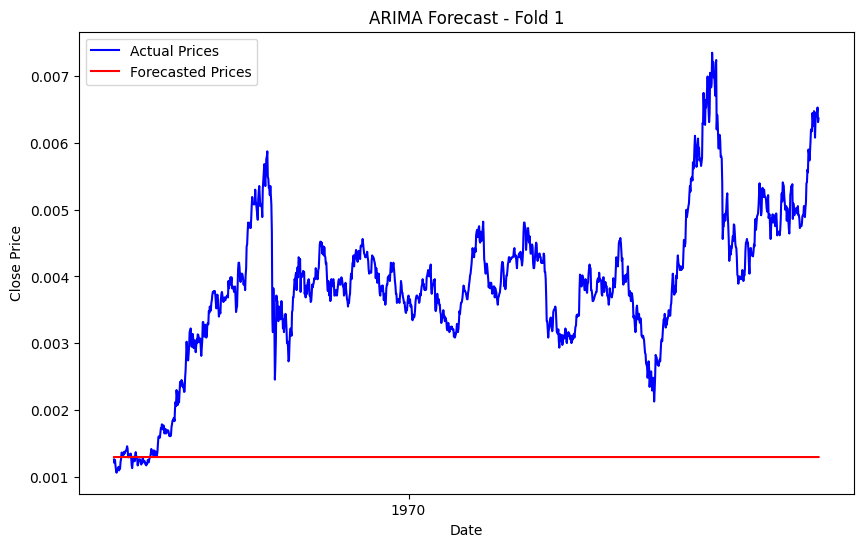

  Best ARIMA Order: (1, 1, 0) with MSE: 0.000008

Processing Fold 2...


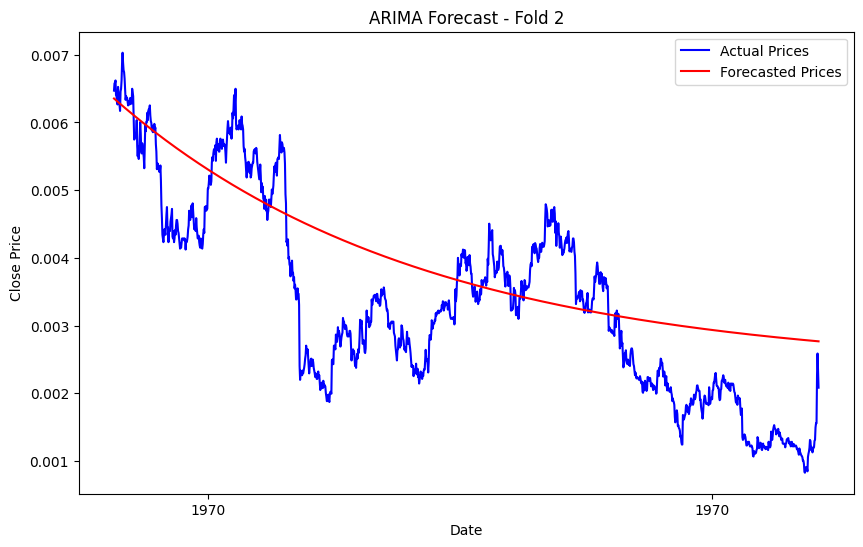

  Best ARIMA Order: (2, 0, 1) with MSE: 0.000001

Processing Fold 3...


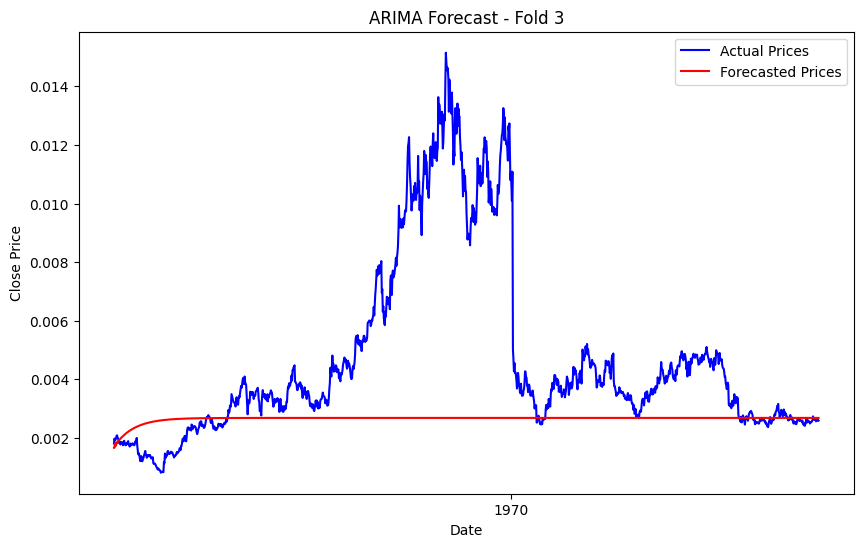

  Best ARIMA Order: (3, 0, 3) with MSE: 0.000014

Processing Fold 4...


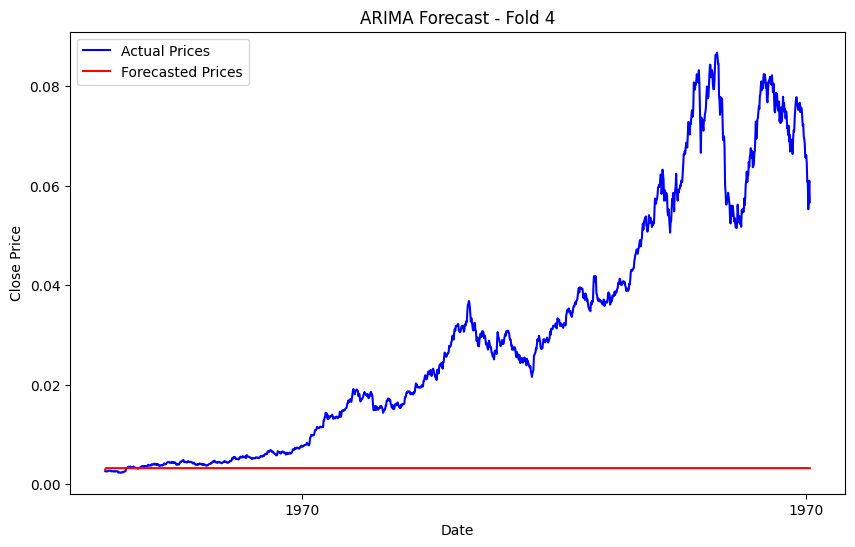

  Best ARIMA Order: (0, 0, 2) with MSE: 0.001303

Processing Fold 5...


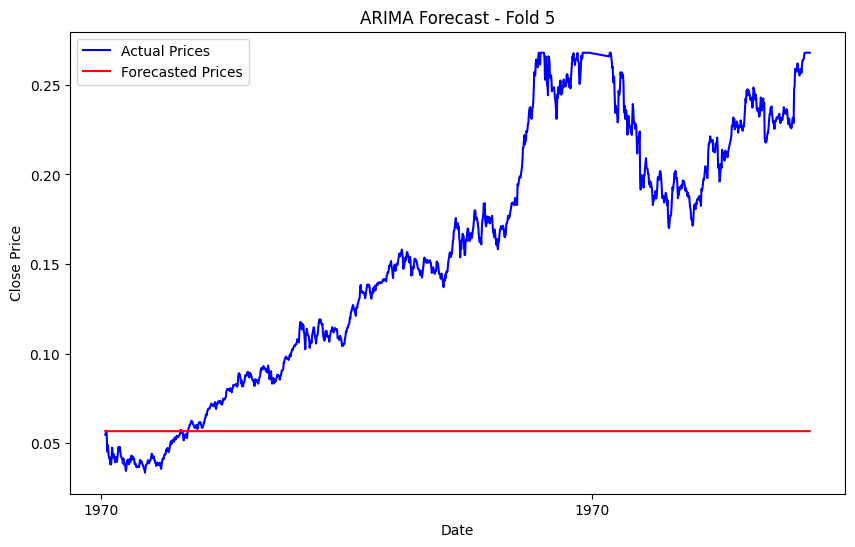

  Best ARIMA Order: (0, 1, 3) with MSE: 0.014617

K-Fold Cross-Validation Results:
Fold 1 - Best Order: (1, 1, 0), MSE: 0.000008
Fold 2 - Best Order: (2, 0, 1), MSE: 0.000001
Fold 3 - Best Order: (3, 0, 3), MSE: 0.000014
Fold 4 - Best Order: (0, 0, 2), MSE: 0.001303
Fold 5 - Best Order: (0, 1, 3), MSE: 0.014617

Average MSE Across Folds: 0.003189 ± 0.005736

Overall Metrics: Mean MSE = 0.003189, Std MSE = 0.005736

Best Overall ARIMA Order: (2, 0, 1) with MSE: 0.000001


In [58]:


if __name__ == "__main__":
    
    p_values = [0, 1, 2, 3]  # Autoregressive terms
    d_values = [0, 1]        # Differencing terms
    q_values = [0, 1, 2, 3]  # Moving average terms

 
    y = data['Close']

    # Training and validating ARIMA
    fold_results, best_order, best_mse = train_validate_arima(y, p_values, d_values, q_values)
     # Saving comparison summary as CSV
    comparison_data = [
        {"Fold": result["Fold"], "Best Order": result["Best Order"], "MSE": result["MSE"]}
        for result in fold_results
    ]
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df.to_csv("results/arima/summary/comparison_summary.csv", index=False)

    # Displaying results
    display_summary(fold_results)

    print(f"\nBest Overall ARIMA Order: {best_order} with MSE: {best_mse:.6f}")


The differencing parameter \( d \) is set to **0** because the preprocessing step already applied **first-order differencing** to the data after confirming its non-stationarity through stationarity tests. As a result, the series was transformed into a stationary form before fitting the ARIMA model, eliminating the need for additional differencing. This ensures the ARIMA model focuses on capturing the underlying temporal patterns without redundant transformations.

Training Final ARIMA Model with Order: (2, 0, 1)...
Test MSE: 0.014146


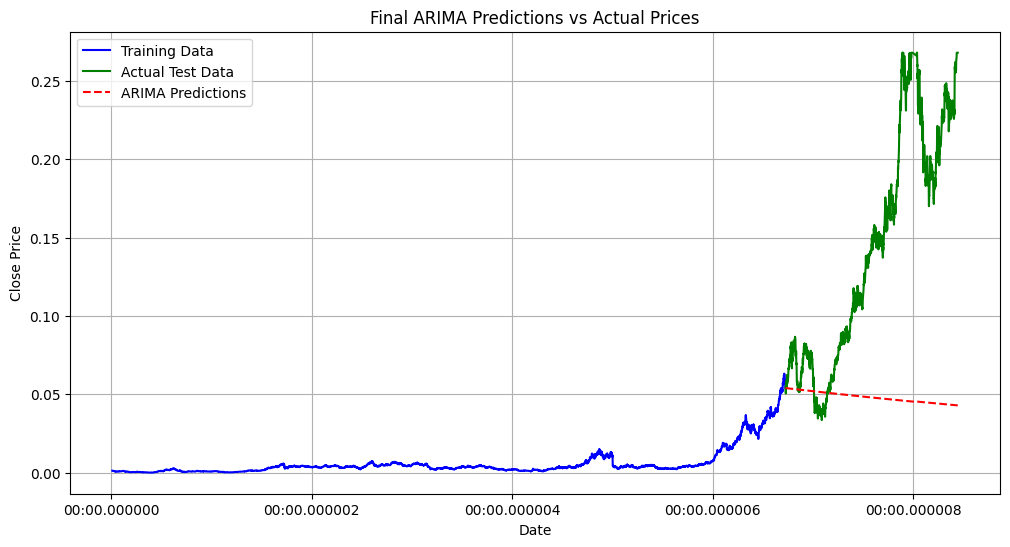

In [59]:


def final_arima_prediction(y_train, y_test, best_order):
    print(f"Training Final ARIMA Model with Order: {best_order}...")
    
    # Train ARIMA model on training data
    model = ARIMA(y_train, order=best_order)
    model_fit = model.fit()
    
    # Forecast on test data
    forecast = model_fit.forecast(steps=len(y_test))
    
    # Calculate MSE
    mse = mean_squared_error(y_test, forecast)
    print(f"Test MSE: {mse:.6f}")
    
    # Plot Actual vs Forecasted Prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.index, y_train, label="Training Data", color="blue")
    plt.plot(y_test.index, y_test, label="Actual Test Data", color="green")
    plt.plot(y_test.index, forecast, label="ARIMA Predictions", color="red", linestyle="--")
    plt.title("Final ARIMA Predictions vs Actual Prices")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()
    
    return forecast, mse


if __name__ == "__main__":
    
    y = data['Close']
    
   
    train_size = int(len(y) * 0.8)
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Best ARIMA Order
    best_order = (2, 0, 1)  #

   
    final_forecast, test_mse = final_arima_prediction(y_train, y_test, best_order)

    np.save("results/arima/summary/final_forecast.npy", final_forecast)
    np.save("results/arima/summary/test_data.npy", y_test)



The ARIMA model with order **(2,0,1)**, trained on the historical stock price data, fails to capture the sharp upward trend and volatility present in the test dataset. The training data exhibits a relatively stable and gradual increase, but the actual test data shows a significant, nonlinear upward movement. As seen in the graph, the ARIMA model's predictions remain **flat**, indicating that it assumes a stationary process with no persistent trend. This static forecast highlights a clear failure of the ARIMA model to generalize to the test data, as it completely underestimates the rising stock prices. This results in a substantial performance gap, reflected visually and likely quantified by a high Mean Squared Error (MSE). The inability to account for the non-stationary nature and volatility of the stock price data confirms that ARIMA is not a suitable model for this dataset, and alternative approaches, such as SARIMA for seasonal trends or deep learning models like LSTMs, are required to handle such dynamic and upward-moving time series effectively.

### Comparing the two models 

In [60]:
def load_arima_results():
    metrics_path = "results/arima/summary/overall_metrics.json"
    # Load results from all folds
    forecasts = []
    actuals = []
    for fold in range(1, 6):
        forecast = np.load(f"results/arima/fold_{fold}/forecast.npy")
        actual = np.load(f"results/arima/fold_{fold}/actual.npy")
        forecasts.append(forecast)
        actuals.append(actual)
    
    with open(metrics_path, "r") as f:
        arima_metrics = json.load(f)
    
    # Concatenate all folds
    arima_forecast = np.concatenate(forecasts)
    arima_actual = np.concatenate(actuals)
    return arima_metrics, arima_forecast, arima_actual

In [61]:
def load_rf_results():
    metrics_path = "results/summary/overall_metrics.json"
    # Load results from all folds
    forecasts = []
    actuals = []
    for fold in range(1, 6):
        forecast = np.load(f"results/fold_{fold}/test_predictions.npy")
        actual = np.load(f"results/fold_{fold}/test_actuals.npy")
        forecasts.append(forecast)
        actuals.append(actual)
    
    with open(metrics_path, "r") as f:
        rf_metrics = json.load(f)
    
    # Concatenate all folds
    rf_forecast = np.concatenate(forecasts)
    rf_actual = np.concatenate(actuals)
    return rf_metrics, rf_forecast, rf_actual

In [62]:
def compare_metrics(arima_metrics, rf_metrics):
    print("\nModel Comparison:")
    print(f"ARIMA: Mean MSE = {arima_metrics['Mean MSE']:.6f}")
    print(f"Random Forest: Mean MSE = {rf_metrics['mean_mse']:.6f}")


In [63]:

def inverse_transform_data(data, scaler):
    # Reshaping data if needed
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    return scaler.inverse_transform(data)


In [64]:
def plot_predictions_split_rf_steps(arima_forecast, arima_actual, rf_forecast, rf_actual, scaler):
    # Inverse transform the data
    arima_forecast = inverse_transform_data(arima_forecast, scaler)
    arima_actual = inverse_transform_data(arima_actual, scaler)
    
    # For RF data, handle multi-step predictions
    rf_forecast_original = np.zeros_like(rf_forecast)
    rf_actual_original = np.zeros_like(rf_actual)
    
    for step in range(rf_forecast.shape[1]):
        rf_forecast_original[:, step] = inverse_transform_data(rf_forecast[:, step].reshape(-1, 1), scaler).flatten()
        rf_actual_original[:, step] = inverse_transform_data(rf_actual[:, step].reshape(-1, 1), scaler).flatten()

    fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

    # Plot ARIMA Predictions vs Actual
    time_indices_arima = np.arange(len(arima_actual))
    axes[0].plot(time_indices_arima, arima_actual, label="Actual (ARIMA)", color="blue", alpha=0.6)
    axes[0].plot(time_indices_arima, arima_forecast, label="ARIMA Predictions", color="red", linestyle="--", linewidth=2)
    axes[0].set_title("ARIMA Predictions vs Actual")
    axes[0].set_ylabel("Price ($)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot RF Predictions for each time step
    time_indices_rf = np.arange(len(rf_actual_original))
    for i, (actual, pred, step) in enumerate(zip(rf_actual_original.T, rf_forecast_original.T, range(1, 4)), 1):
        axes[i].plot(time_indices_rf, actual, label=f"Actual (t+{step})", color="blue", alpha=0.6)
        axes[i].plot(time_indices_rf, pred, label=f"RF Predictions (t+{step})", 
                    color=["green", "orange", "purple"][i-1], linestyle="--", linewidth=2)
        axes[i].set_title(f"Random Forest Predictions vs Actual (t+{step})")
        axes[i].set_ylabel("Price ($)")
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Time Index")
    plt.tight_layout()
    plt.show()


Model Comparison:
ARIMA: Mean MSE = 0.003189
Random Forest: Mean MSE = 0.002237


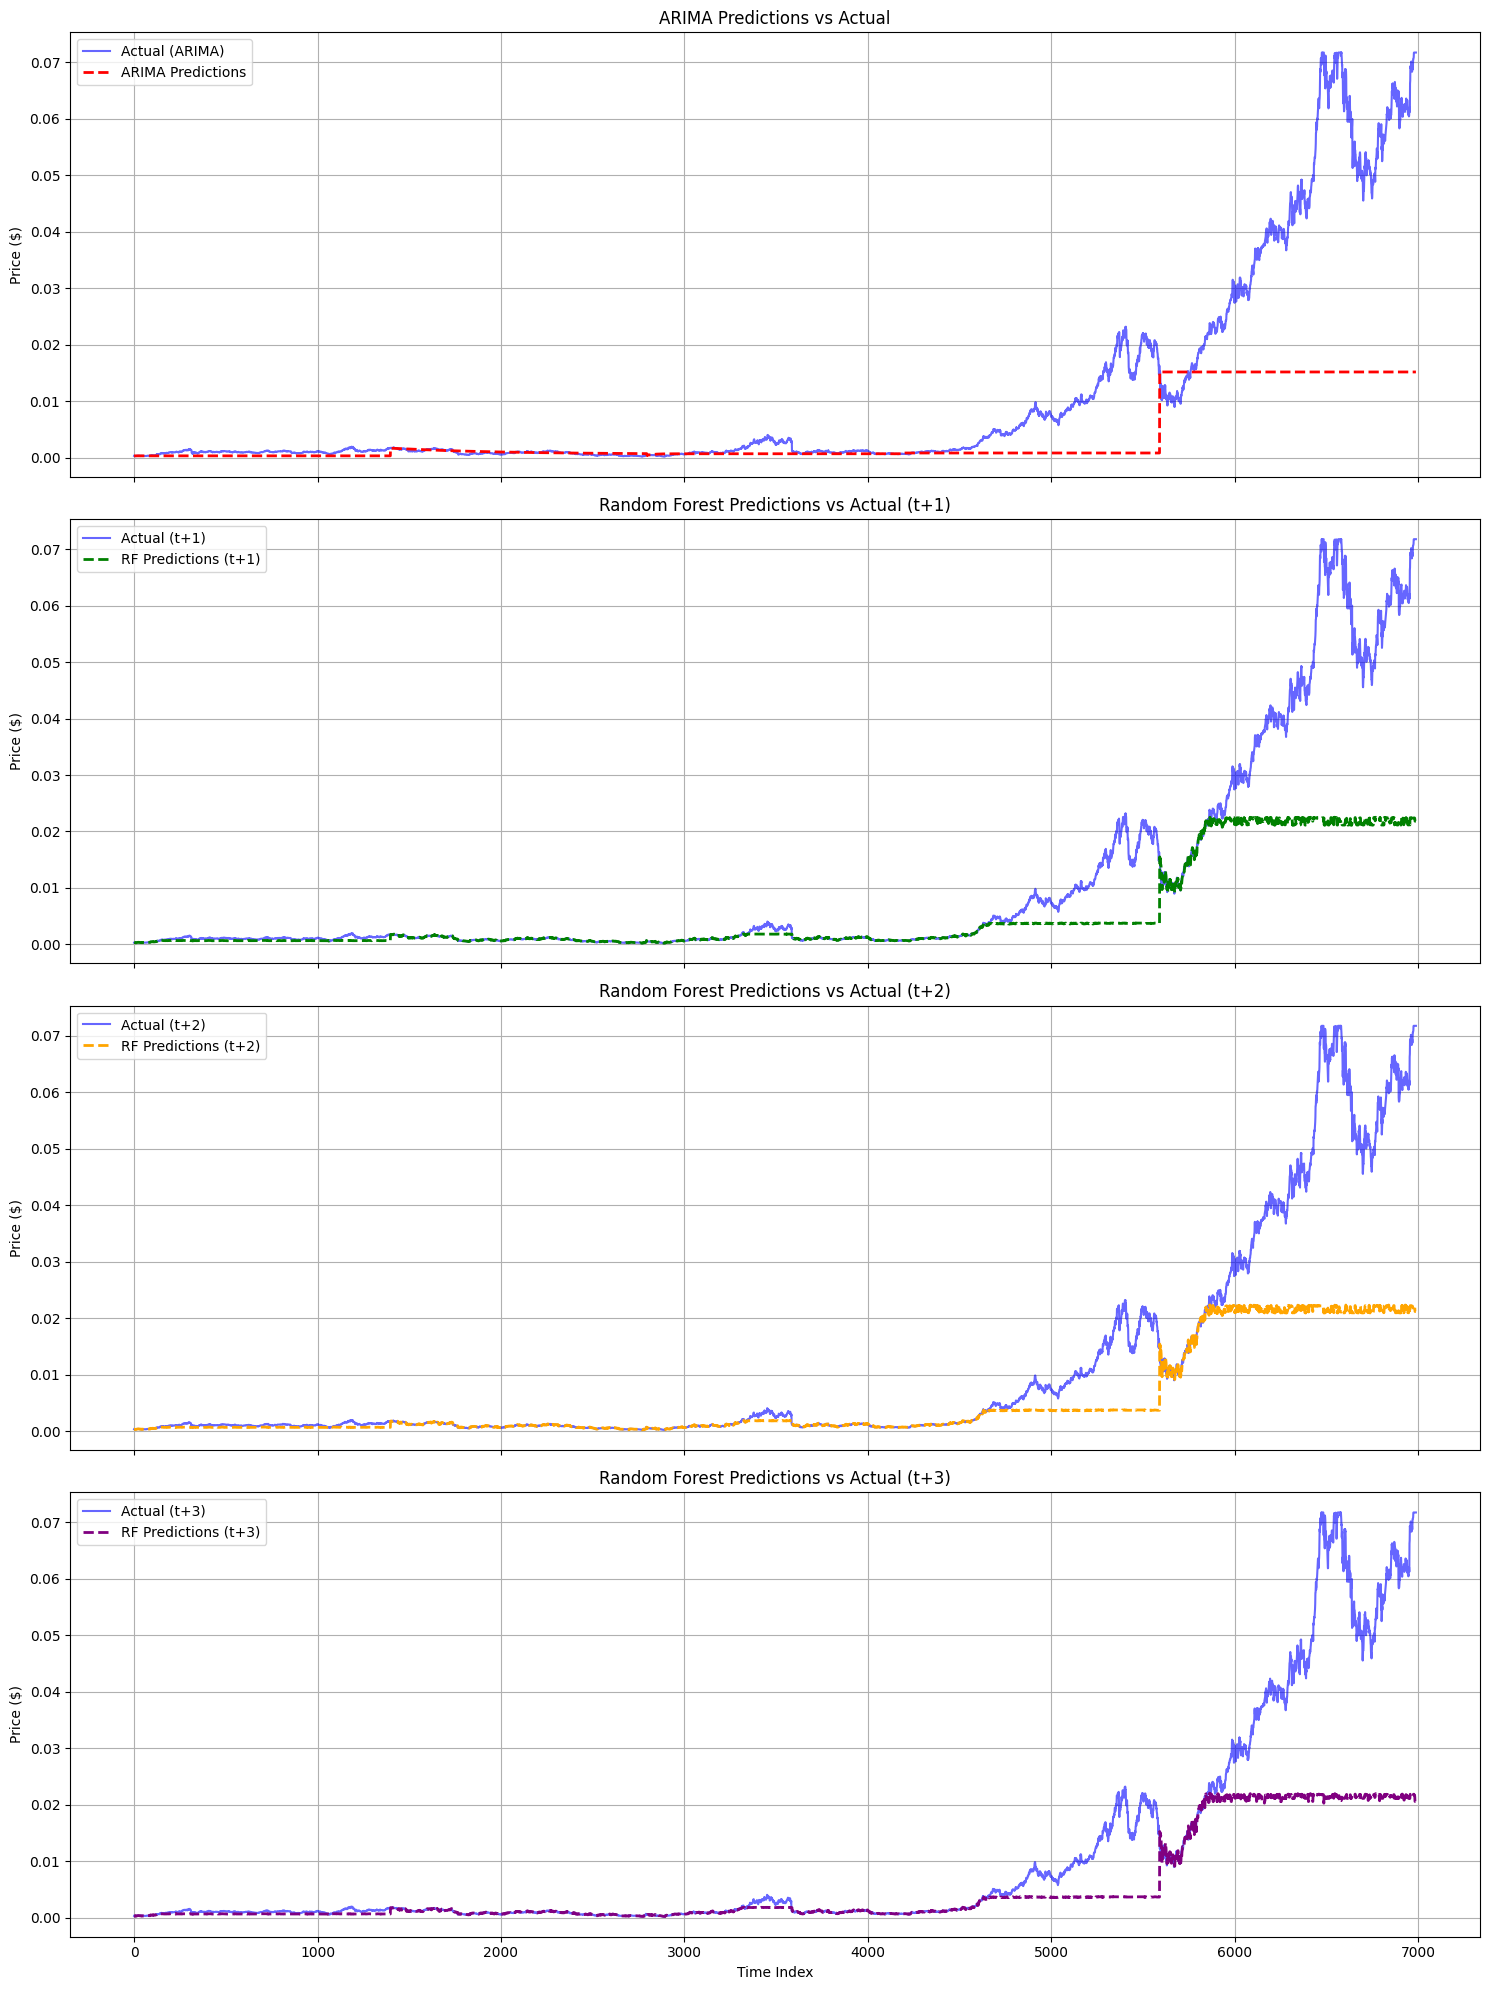

In [65]:


# Main execution
if __name__ == "__main__":
    # Initialize and fit scaler using the existing data
    scaler = MinMaxScaler()
    scaler.fit(data[['Close']].values)
    
    # Load results
    arima_metrics, arima_forecast, arima_actual = load_arima_results()
    rf_metrics, rf_forecast, rf_actual = load_rf_results()

    # Compare metrics
    compare_metrics(arima_metrics, rf_metrics)

    # Plot predictions
    plot_predictions_split_rf_steps(arima_forecast, arima_actual, rf_forecast, rf_actual, scaler)

The function plot_predictions_split_rf_steps visually compares predictions made by two models, ARIMA and Random Forest (RF), against actual values in a time-series regression task. The function performs inverse transformations on the scaled data using the provided scaler to convert it back to its original scale.

For ARIMA, it plots a single line comparing actual stock prices against ARIMA's forecasted values over the same time indices.

For Random Forest, which handles multi-step predictions (e.g., t+1, t+2, t+3), it reconstructs the predictions and actual values for each prediction horizon (steps). The function then plots each prediction step (t+1, t+2, t+3) in separate subplots, displaying actual values alongside Random Forest forecasts. Each subplot uses distinct colors to differentiate prediction steps clearly.

### Choosing a model

Based on the results, I find that the **Random Forest** model performs better for this specific stock (AAPL), achieving a **lower Mean Squared Error (MSE)** of **0.002237** compared to **0.003189** for the ARIMA model. This difference suggests that the Random Forest model is able to capture the short-term relationships and non-linear patterns in the data more effectively, likely due to the engineered features such as lag values, rolling means, and RSI. Random Forest's ensemble nature helps it generalize better over small, noisy datasets, which may explain its superior performance for this particular stock.

However, it’s important to note that this analysis is limited to a single stock. When considering a larger number of stocks, especially those with strong linear trends or seasonality, the results might favor ARIMA. ARIMA’s ability to model temporal dependencies explicitly often makes it a more suitable choice for datasets where sequential relationships dominate, such as in long-term forecasting scenarios or for stocks that exhibit clear trends. In contrast, Random Forest struggles to capture the time-series nature directly since it doesn’t inherently account for sequence order. For a more generalized conclusion across multiple stocks, I would need to evaluate both models on a larger, diverse dataset, and in such cases, ARIMA might emerge as the more consistent performer.

### Ethical Concerns

Training models on datasets like **stock market data** raises several ethical concerns, particularly regarding **data privacy, market manipulation, and fairness**. While stock market data, such as AAPL's historical prices, is publicly available, the insights and predictions generated by models trained on such data can disproportionately benefit entities with access to advanced tools, potentially exacerbating inequality. For example, large financial institutions or firms using predictive models can exploit these insights for high-frequency trading or gaining unfair advantages, leaving smaller investors at a disadvantage. Furthermore, reliance on such models could contribute to market volatility if automated systems act on predictions simultaneously. Additionally, ethical questions arise when using historical data to forecast future performance, as models may unintentionally propagate biases or overlook external factors like economic crises, social issues, or corporate governance. Ensuring transparency, fairness, and responsible deployment of these models is essential to prevent misuse and promote equity in financial systems.

### Bibliography



**References**  
1. Statistics Solutions. "Stationary Data Assumption in Time Series Analysis." Available at: [https://www.statisticssolutions.com/stationary-data-assumption-in-time-series-analysis/](https://www.statisticssolutions.com/stationary-data-assumption-in-time-series-analysis/)  
2. MachineLearningPlus. "Augmented Dickey-Fuller Test." Available at: [https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)  
3. BYJU'S. "Null Hypothesis." Available at: [https://byjus.com/maths/null-hypothesis/](https://byjus.com/maths/null-hypothesis/)  

4. Hyndman, Rob J., & Athanasopoulos, George. *"Forecasting: Principles and Practice."* Available at: [https://otexts.com/fpp2/stationarity.html](https://otexts.com/fpp2/stationarity.html)  

5. Firdose, Tahera. "Treating Outliers Using IQR and Percentile Approach." Medium. Available at: [https://tahera-firdose.medium.com/treating-outliers-using-iqr-and-percentile-approach-part-2-9d8c4ec55af7](https://tahera-firdose.medium.com/treating-outliers-using-iqr-and-percentile-approach-part-2-9d8c4ec55af7)


6. Investopedia. "Relative Strength Index (RSI)." Available at: [https://www.investopedia.com/terms/r/rsi.asp#:~:text=The%20relative%20strength%20index%20(RSI,scale%20of%20zero%20to%20100](https://www.investopedia.com/terms/r/rsi.asp#:~:text=The%20relative%20strength%20index%20(RSI,scale%20of%20zero%20to%20100)).


7. Reddit. *"Time Series Forecasting with Random Forest."* Available at: [https://www.reddit.com/r/datascience/comments/15rhb54/timeseries_forecasting_with_random_forest/](https://www.reddit.com/r/datascience/comments/15rhb54/timeseries_forecasting_with_random_forest/)  


8. Scikit-learn. *"RandomForestRegressor — scikit-learn 1.5 documentation."* Available at: [https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


9. Towards Data Science. "Grid Search for Model Tuning." Available at: [https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e).

10. Dremio. "What is Grid Search?" Available at: [https://www.dremio.com/wiki/grid-search/](https://www.dremio.com/wiki/grid-search/)  

11. Investopedia. *"Autoregressive Integrated Moving Average (ARIMA)."* Available at: [Investopedia ARIMA](https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp).  

12. Machine Learning Mastery. *"ARIMA for Time Series Forecasting."* Available at: [Machine Learning Mastery ARIMA](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).  

13. Santra, Ritu. "Tests for Stationarity in Time Series: Dickey-Fuller Test & Augmented Dickey-Fuller (ADF) Test." Medium, available at: [https://medium.com/@ritusantra/tests-for-stationarity-in-time-series-dickey-fuller-test-augmented-dickey-fuller-adf-test-d2e92e214360](https://medium.com/@ritusantra/tests-for-stationarity-in-time-series-dickey-fuller-test-augmented-dickey-fuller-adf-test-d2e92e214360).  

14.  GeeksforGeeks. "Interquartile Range to Detect Outliers in Data." Available at: https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/.

15. ListenData, *"Right Skewed Histogram: Reasons and Interpretation"*, 2023. [Online]. Available: https://www.listendata.com/2023/08/right-skewed-histogram.html#:~:text=Reasons%20for%20Right%20Skewed%20Histogram&text=Few%20High%20Values%3A%20There%20will,be%20greater%20than%20the%20median.

16. Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: Principles and Practice* (2nd ed.). OTexts. Available online: [https://otexts.com/fpp2/](https://otexts.com/fpp2/)  
